In [1]:
#First set everthing up
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.stats as sy
import pylab
import seaborn as sns
import geopandas as gpd
import fiona as fi
import math
from sklearn import mixture
from sklearn import metrics
import sklearn as sk
from matplotlib.backends.backend_pdf import PdfPages
from __future__ import division # convert integer division to floating point
%matplotlib inline
sns.set(color_codes=True)
plt.rcParams['font.size'] = 11
plt.tight_layout;
plt.rc('xtick', labelsize=11) 
plt.rc('ytick', labelsize=11) 

## Part A: Utility Functions

Let's create a function that diplay histograms of specific dataframe features

In [2]:
# df is the dataframe that we are trying to characterize
# features is an array of features we would like to create histograms of 

def cluster_histograms(df, features):
    plt.style.use('ggplot')
    for feat in features:
        x = df[feat]
        plt.hist(x, range=[-4, 4], normed=True, bins=7)
        plt.ylabel('Probability')
        plt.xlabel(feat)
        plt.figure(1)
        plt.show()

Let's create a function that displays histograms with Kernel Density Estimates of Specific Features

In [3]:
# df is the dataframe that we are trying to characterize
# features is an array of features we would like to create histograms of 

def cluster_dist_plots(df, features):
    plt.style.use('ggplot')
    for feat in features:
        x = df[feat]
        sns.distplot(x)

Let's create a function that displays a two column grid of a set histograms with Kernel Density Estimates of Specific Features

In [4]:
def formatted_histograms(df, features):
    plt.style.use('ggplot')
    k = len(features)
    n = 2 # columns
    m = (k - 1) // n + 1 # rows
    fig, axes = plt.subplots(m, n, sharex=False, figsize=(n * 9, m * 5)) # set up the axes and the figures
    for i, (name, col) in enumerate(df[features].iteritems()):
        r, c = i // n, i % n
        ax = axes[r, c]
        col.hist(ax=ax)
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        ax2.set_ylim(0)
        plt.axvline(x=0)
        pylab.xlim([-3,3])
    fig.tight_layout()

Now, let's create a function that takes a matrix of features, a full dataframe, and the number of culsters to be created and returns a list of the dataframes subsetted into these clusters.

In [5]:
# data is the subset of data used to do the clustering
# frame is the full dataframe of points to be clustered
# num_clusters is the number of clusters to be created
# returns a list of dataframes (subsets of frame), each subseted to contain points assigned to a specific cluster,
# the actual model object, and a new version of the 'frame' dataframe containing cluster
# labels in a new column called 'cluster'

def pct_cluster(data, frame, num_clusters):
    model = mixture.GaussianMixture(n_components=num_clusters, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=10000, n_init=100, 
                                 init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=100, 
                                 warm_start=False, verbose=0, verbose_interval=10)
    model = model.fit(data)
    labels = model.predict(data) # cluster labels
    probability = model.predict_proba(data) # posterior probabilities
    ### create a column 'cluster' that contains the cluster number assigned to each precinct
    frame['cluster']=labels
    ### add columns at the end of the dataframe conatining the probabilty scores for each potential cluster
    frame = pd.concat([frame,pd.DataFrame(probability)],axis=1)
    ### create a column 'cluster_strength' that contains the probability of a precinct actually being in it's assigned cluster
    frame['cluster_strength'] = frame.apply(lambda x: x[x['cluster']], axis=1)
    clusters = [None]*num_clusters
    ### create a list of clusters, one element for each cluster, each element containing all precicts assigned to that cluster
    for i in xrange(num_clusters):
        df = frame[frame['cluster']== i]
        clusters[i]=df
    return clusters, model, frame 

Create a function to characterize a set of clusters by displaying names, sizes, and histograms of key features

In [6]:
# clusters is a list of dataframes 
# features is an array of features to characterize

def characterize(clusters, features_list, name_array):   
    for i in xrange(len(clusters)):
            df = clusters[i]
            df = df[features_list[i]]
            print('Cluster ' + str(i) + ' is called '+ name_array[i])
            print('Cluster ' + str(i) + ' has the following size: ' + str(len(df)))
            print('Cluster ' + str(i) + ' has the following charateristics: \n' + str(df.mean()))
            formatted_histograms(df, features_list[i])
            plt.show()
            print(' ')

Let's create a function to strip blanks from string fields

In [7]:
def strip_blanks(x):
    return x.replace(" ", '')

## Part B: Data Import and Preparation

Read in both the raw and standardized precinct data.  Note that this data has been matched to the geojson file provided by the board of elections for the 11/2016 general election.  This goejson file has two precincts that we cannot cluster due to lack of demographic data: Wake 16-08 and Wake 19-10.  Also note that we have four precincts that we will cluster  that are not in the geojson file:  Wake 16-10, Wake 16-11, Wake 19-18 and Wake 19-19.  We suspect that Wake 16-08 was split in two (16-10 and 16-11) and that Wake 19-10 was also split in two (19-18 and 19-19).  This needs to be verified, but for now we will manually pick the cluster of 16-08 and 19-10 based upon clustering results for the new precincts.

standardized_data will contain data for the precincts that have all been standardized to a mean of 0 and a standard deviation of 1.  This will put all data dimenstions on the same scale.

raw_data will contain the raw data for the precincts.

In [8]:
standardized_data = pd.read_csv('combined_pct_final_clustering.csv')
raw_data = pd.read_csv('combined_pct_final_unst_clustering.csv')

We define a funtion called 'logistic' that converts a data feature having a domain of - infinity to + infinity to a domain of 0 to 1.  This will be useful for visualization.

In [9]:
def logistic(x):
    return (1/(1+math.exp(-x)))

For future display purposes, we will apply a logistic transformation to 'trump_premim' to create a new column 'trump_premium_l'.  This new column will take a value beteeen 0 and 1, with 0 being a large negative premium, 0.5 being no premium, and 1 being a very large postivitive trump premium.

In [10]:
raw_data.loc[ : , 'trump_premium_l'] = raw_data['trump_premium']*10
raw_data.loc[ : , 'trump_premium_l'] = raw_data['trump_premium_l'].apply(logistic)

In [11]:
print standardized_data.columns

Index([u'Unnamed: 0', u'county_pct', u'population', u'asian', u'black',
       u'indian', u'mixed', u'other_race', u'white', u'DEM', u'LIB', u'REP',
       u'hispanic_latino', u'not_latino', u'female', u'male', u'has_license',
       u'NC_born', u'No_birth_state', u'registr_post_2000', u'median_age',
       u'UNA', u'NON_NC_born', u'fraction_newton', u'fraction_trump',
       u'trump_premium', u'2016', u'2015', u'2014'],
      dtype='object')


Let's create some sets of features, including one set without political parties

In [12]:
small_features = ['white', 'REP', 'trump_premium', 'fraction_trump'] 
medium_features = small_features + ['median_age', 'NON_NC_born', 'hispanic_latino', '2016', 'UNA', 'female']
medium_high_features = medium_features + ['asian', 'black', 'DEM']
large_features = medium_high_features + ['indian', 'has_license']
small_subset = standardized_data[small_features]
medium_subset = standardized_data[medium_features]
medium_high_subset = standardized_data[medium_high_features]
large_subset = standardized_data[large_features]
large_subset_without_parties = large_subset.drop(['DEM','REP','UNA'], axis=1, inplace=False) # remove political parties
print large_subset_without_parties.columns

Index([u'white', u'trump_premium', u'fraction_trump', u'median_age',
       u'NON_NC_born', u'hispanic_latino', u'2016', u'female', u'asian',
       u'black', u'indian', u'has_license'],
      dtype='object')


## Part C: Two Clusters

We now use PCA (Principal Component Analysis) to serve as a 'low-pass filter' and reduce noise in the clustering.   A review of the literature indicates that data must be standardized prior to PCA, but transformation to a normal distribution is not necessary (since inference will not be done).

Note that I performed clustering experiments without using PCA, but the results were noisy and not acceptable.

Let's start with the full set of data without political parties.  As a baseline, we will group these into two clusters.

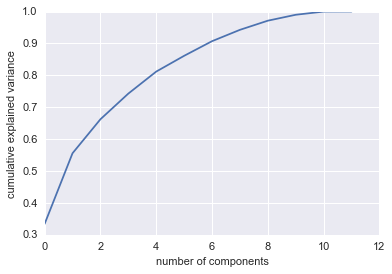

In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(large_subset_without_parties)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [14]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.33396367,  0.55560458,  0.66220172,  0.74270254,  0.81173238,
        0.8611734 ,  0.90708087,  0.9426685 ,  0.97135467,  0.98991984,
        0.99986429,  1.        ])

To do our clustering, we need to select the 'best' number of principal components.  In a 2 cluster project, we define 'best' as the number of principal components that yields the most balanced cluster sizes.  We need to select the number of principal components that balances the clusters.  There are 2704 precincts, so we're looking for a number of between 1300 and 1600 

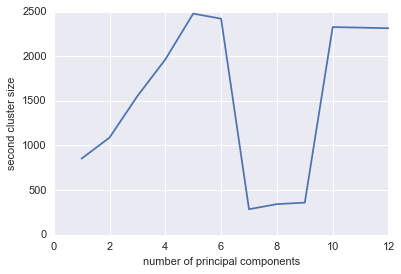

In [15]:
second_clust_count = pd.Series(np.nan, index=range(1,13), dtype='float')
for i in range(1,13):
    pca = PCA(n_components=i)
    synthetic = pca.fit_transform(large_subset_without_parties)
    dummy, dummy, frame = pct_cluster(synthetic, standardized_data, num_clusters=2)
    second_clust_count[i] = sum(frame['cluster']==1.0)
plt.plot(second_clust_count)
plt.xlabel('number of principal components')
plt.ylabel('second cluster size')

Three principal components yields the most balanced clusters, so we will select this. Note that the 3 principal components will contain approximately 2/3 of the total variance (or signal).

In [16]:
pca = PCA(n_components=3)
synthetic = pca.fit_transform(large_subset_without_parties)

The matrix 'synthetic' contains the values for the 3 synthetic features.  This will be used for clustering.

In [17]:
clusters, model, standardized_data_clusters = pct_cluster(synthetic, standardized_data, 
                                                               num_clusters=2)
dummy, dummy, raw_data_clusters = pct_cluster(synthetic, raw_data,  num_clusters=2)

In [18]:
feature_set_0 = ['white', 'fraction_trump', 'trump_premium', 'black', 'NON_NC_born', 'median_age', '2016', 'hispanic_latino', 'indian', 'asian']
feature_set_1 = ['white', 'fraction_trump', 'trump_premium', 'black', 'NON_NC_born', 'median_age', '2016', 'hispanic_latino', 'indian', 'asian']
feature_set = [feature_set_0, feature_set_1]

Next, to visualize the clustering and other characteristics of the precincts, we will read in a geojson file containing the geometry of the features and 2016 presidential election voting. 

In [19]:
nc_map = gpd.read_file('pres2016precincts.geojson')

Let's see how many precincts are in the geogson dataframe vs. the cluster dataframe

In [20]:
len(nc_map), len(raw_data_clusters)

(2704, 2706)

This makes sense. The geojson dataframe has 2 precincts that are not in the cluster dataframe.  But the cluster dataframes have 4 precincts that are not in 'nc_map'.  This accounts for the differnences.

Now we do a left join of the cluster dataframe to the geojson dataframe.  

First, we need to add the key field 'county_pct' to the geojson dataframe.  We form this new column by concatenating county name and precinct name.

In [21]:
nc_map.loc[ : ,'county_pct'] = nc_map['COUNTY_NAM'].map(str) + nc_map['PREC_ID'].map(str)
nc_map.loc[ : ,'county_pct'] = nc_map['county_pct'].apply(strip_blanks)

Now we do left joins to create combinded dataframes for both the standardized and the raw data

In [22]:
raw_nc_map = nc_map.merge(raw_data_clusters, on='county_pct', how='left')
standardized_nc_map = nc_map.merge(standardized_data_clusters, on='county_pct', how='left')

Now we fix WAKE16-08 and WAKE19-10

In [23]:
raw_nc_map.loc[raw_nc_map['county_pct']=='WAKE16-08', 'cluster']=1
raw_nc_map.loc[raw_nc_map['county_pct']=='WAKE19-10', 'cluster']=1

Let's set up two functions.  cluster_definitions returns a 'cluster name' based upon the cluster number.  cluster_colors returns a color code based upon the cluster number.

In [24]:
def cluster_definitions(x):
    if x == 0.0:
        return 'Zero'
    elif x == 1.0:
        return 'One'
    else:
        return 'No Cluster'

Now we add cluster defintions

In [25]:
raw_nc_map.loc[ : ,'cluster_definition'] = raw_nc_map['cluster'].apply(cluster_definitions)
raw_nc_map = raw_nc_map[raw_nc_map['cluster_definition']!='No Cluster']

Let's look at the how many precincts are in each cluster.

In [26]:
print('The number of Precincts in Cluster 0 is ' +str(sum(raw_nc_map['cluster_definition']=='Zero')))
print('The number of Precincts in Cluster 1 is ' +str(sum(raw_nc_map['cluster_definition']=='One')))

The number of Precincts in Cluster 0 is 1150
The number of Precincts in Cluster 1 is 1554


Now we create the cluster map

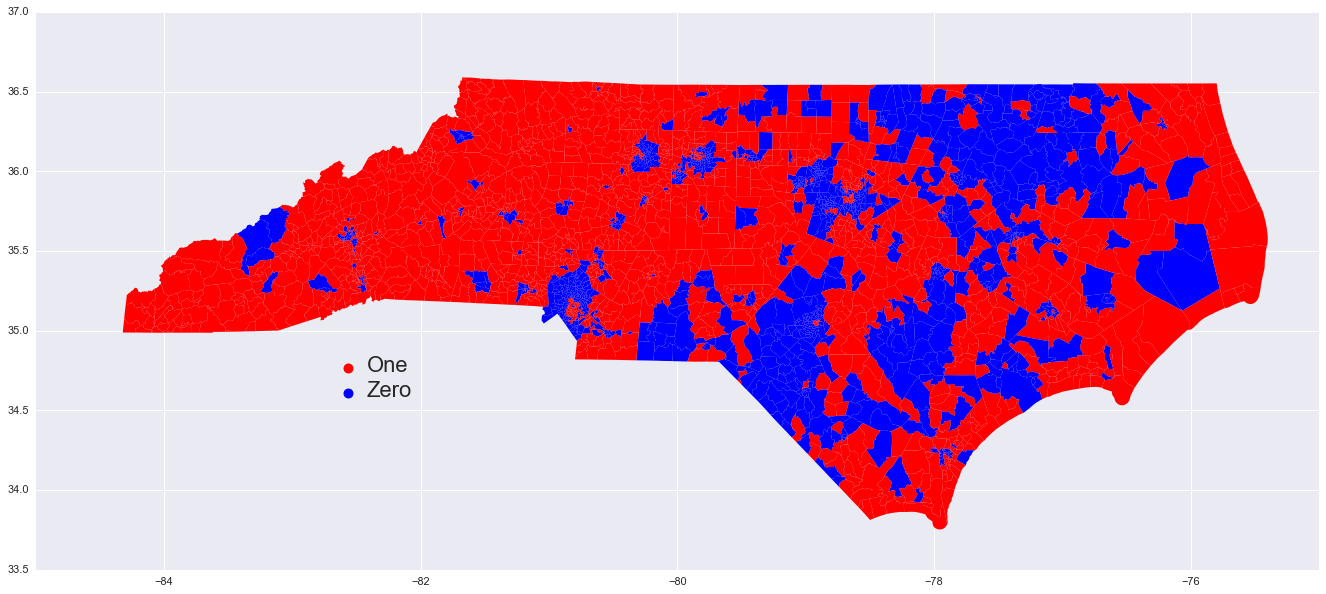

In [27]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'red'), (1, 'blue')])

f, ax = plt.subplots(1, figsize=(23, 10))
ax = raw_nc_map.plot(column = 'cluster_definition', cmap=cmap, ax=ax, edgecolors='none',categorical=True, 
                      k=2,legend=True, alpha=1)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))
plt.setp(leg.get_texts(), fontsize='22') # for legend text
plt.setp(leg.get_title(), fontsize='32') # for legend title
plt.show()

Let's compare this with a simple map on percent democratic > republican

In [28]:
raw_nc_map['political_definition'] = np.where(raw_nc_map['DEM']> raw_nc_map['REP'], 'Democratic', 'Republican')

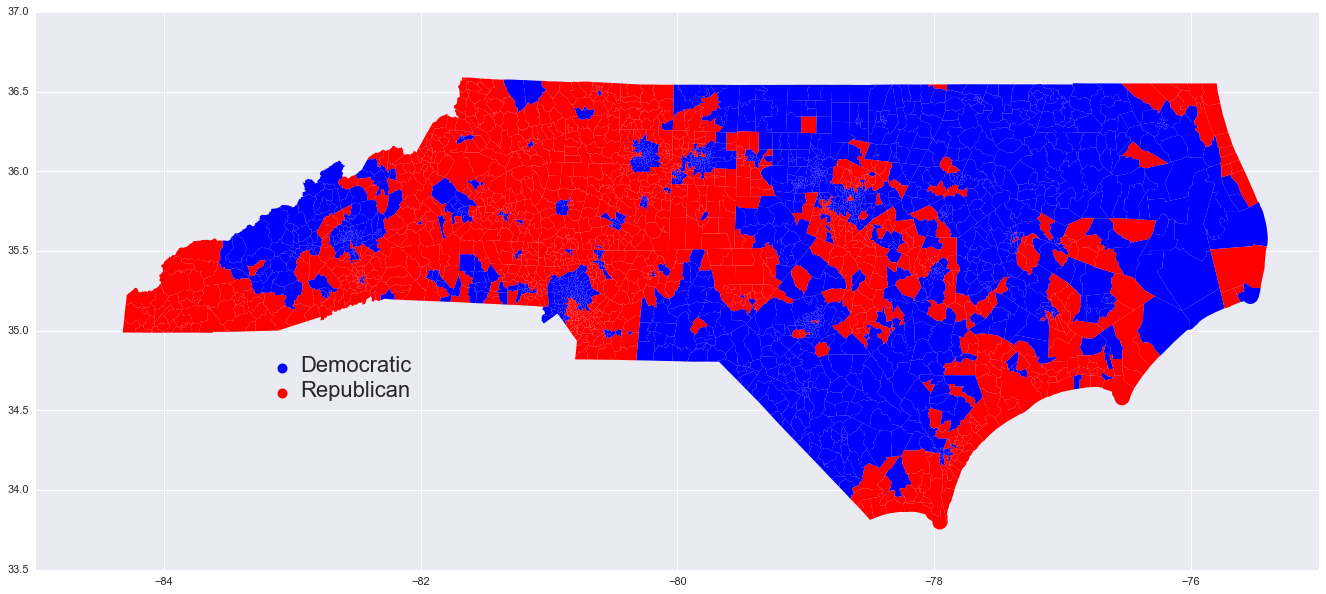

In [29]:
cmap = LinearSegmentedColormap.from_list('mycmap', [(0, 'blue'), (1, 'red')])
f, ax = plt.subplots(1, figsize=(23, 10))
ax = raw_nc_map.plot(column = 'political_definition', cmap=cmap, ax=ax, edgecolors='none',categorical=True, 
                      k=2,legend=True, alpha=1)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))
plt.setp(leg.get_texts(), fontsize='22') # for legend text
plt.setp(leg.get_title(), fontsize='32') # for legend title
plt.show()

The two maps above looks very similar to each other, but there is more blue (democratic) on the political map.   Now, let's create a heat map on fraction of voters registered as democratic.

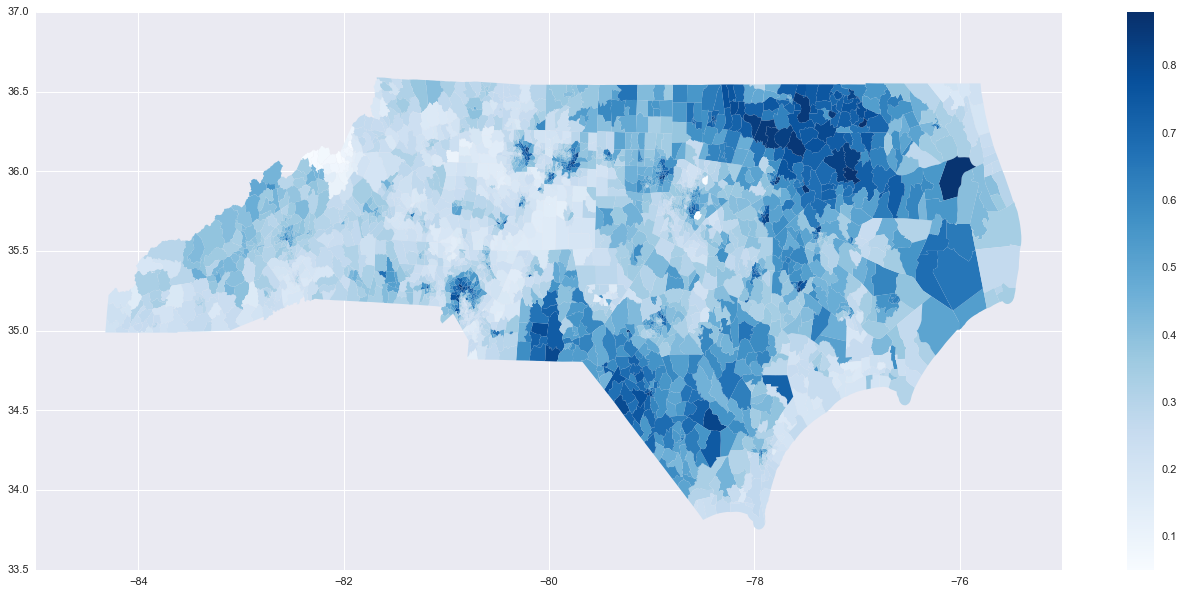

In [30]:
f, ax = plt.subplots(1, figsize=(23, 10))
ax = raw_nc_map.plot(column = 'DEM', cmap='Blues', ax=ax, edgecolors='none',categorical=False, 
                      legend=True, alpha=1)
leg = ax.get_legend()
plt.show()

It looks like our clustering based upon non-political labels is very consistent with political clustering. 


## Part D - Multiple Clusters Model Selection


We now again use again use PCA (Principal Component Analysis, but now we use almost the full set of data with political parties.  We will need to figure out the best number of principal components to use.

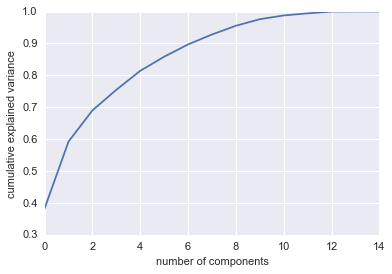

In [31]:
pca = PCA().fit(large_subset)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [32]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.3827729 ,  0.59241346,  0.6900017 ,  0.75478412,  0.81421527,
        0.85842627,  0.8969018 ,  0.92816621,  0.95544192,  0.97608963,
        0.98780034,  0.99438497,  0.99989112,  0.99999491,  1.        ])

For now, let's examine all 15 of the features in our clustering model selection.

In [33]:
feature_set_0 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_1 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_2 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_3 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_4 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_5 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_6 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_7 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set_8 = ['fraction_trump', 'trump_premium', 'black','white','hispanic_latino', 'indian', 'asian', 'REP', 'DEM', 'UNA', '2016', 'NON_NC_born', 'median_age', 'has_license']
feature_set = [feature_set_0, feature_set_1, feature_set_2, feature_set_3, feature_set_4,
              feature_set_5, feature_set_6, feature_set_7, feature_set_8]

Since Guassian Mixture Models provides for 'soft assignment', a precinct is not assigned to a cluster 100%. Instead, each precinct is assigned a probablity of belonging to each cluster.  This can range from 0 to 1, with 1 being a 'hard assignment' and 0 being far away from a cluster.  We define 'cluster strength' as the proability that each precinct is really a member of its assigned cluster.  'Cluster Strength' is already a column in our dataframe.  One way to characterize the strength of a clustering model is to create a statistic called 'tightness', which is the mean of the mean 'cluster strengths' for each cluster.  We will use this below.

Let's create a modified version of the 'characterize' function with this new 'tightness' statistic and also with a new statistic called 'interest'  We hypothesize that a cluster is more interesting if it has a wide variation in the standardized feature means.  For example, if a cluster has all feature means (standardized) near a single number (hence a low variance), it is not interesting.  If on the other hand, it the feature means vary a lot (hence a high variance) the cluster is interesting.  

Note that theoretically, a cluster with low variance but a very high or low mean of feature means would be interesting.  However, since most features are mutually exclusive, this is highly unlikely

In [34]:
# clusters is a list of dataframes 
# features is an array of features to characterize
# return the average variance, and the number of uninteresting clusters

def characterize_interest(clusters, features_list, verbose=False): 
    varianceS = pd.Series(np.nan, index=range(0,len(clusters)-1), dtype='float')
    tightnessS = pd.Series(np.nan, index=range(0,len(clusters)-1), dtype='float')
    for i in xrange(len(clusters)):
            df_full = clusters[i]
            df = df_full[features_list[0]]
            if verbose:
                print('Cluster ' + str(i) + ' has the following size: ' + str(len(df)))
                print('Cluster ' + str(i) + ' has the following means: \n' + str(df.mean()))
                print('Cluster ' + str(i) + ' has an average of means of: ' + str(df.mean().mean()))
                print('Cluster ' + str(i) + ' has an variance of means of: ' + str(df.mean().var()))
                print('Cluster ' + str(i) + ' has a tightness of: ' + str(df_full['cluster_strength'].mean()))
                print(' ')
                formatted_histograms(df, features_list[i])
                plt.show()
            varianceS[i]= df.mean().var()
            tightnessS[i]= df_full['cluster_strength'].mean()
    if verbose:
        print('The avearage variance of the clusters is: ' + str(varianceS.mean()))
        print('The number of uninteresting clusters is: ') + str(sum(varianceS < 0.4))
        print('The average tightness of the clusters is: ') + str(tightnessS.mean())
    return(varianceS.mean(), sum(varianceS < 0.4), tightnessS.mean())

Let's create a function to evaluate the specific models for various numbers of principal components

In [35]:
def evaluate_models(synthetic, lower, upper, num_components):
    mean_varianceS = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    num_uninteresting = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    tightnessS = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    bicS = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    aicS = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    loglS = pd.Series(np.nan, index=range(lower, upper+1), dtype='float')
    for i in range(lower, upper+1):
        clusters, model, standardized_data_clusters = pct_cluster(synthetic, standardized_data, num_clusters=i)
        mean_variance, uninteresting, tightness = characterize_interest(clusters, feature_set, False)
        mean_varianceS[i]=mean_variance
        num_uninteresting[i]=uninteresting
        tightnessS[i]=tightness
        bicS[i]=model.bic(synthetic)
        aicS[i]=model.aic(synthetic)
        loglS[i]=model.score(synthetic)

    print('The Number of Principal Components is: ' +str(num_components))    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(mean_varianceS)
    ax1.set_ylabel('mean variance', color='b')
    ax1.set_xlabel('number of clusters')

    ax2 = ax1.twinx()
    ax2.bar(range(lower, upper+1),num_uninteresting, alpha=0.2, color='r')
    ax2.set_ylabel('number of uninteresting clusters', color='r')

    fig.tight_layout()
    plt.show() 

    plt.plot(tightnessS)
    plt.xlabel('number of clusters')
    plt.ylabel('tightness')
    plt.show()
    
    plt.plot(bicS, label='BIC')
    plt.plot(aicS, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('number of clusters')
    plt.show()
    
    plt.plot(loglS, label='Log Likelihood')
    plt.legend(loc='best')
    plt.xlabel('number of clusters')
    plt.show()

We now examine clustering using 2, 3, 4, 5, and 6 principal components.  In previous experiments, I had tested a higher number but the cluster models were not satisfactory.

The Number of Principal Components is: 2


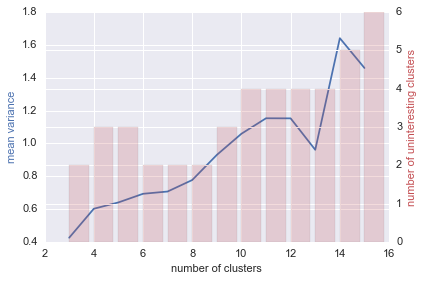

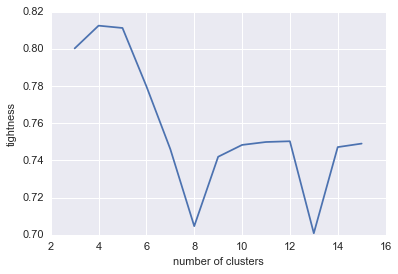

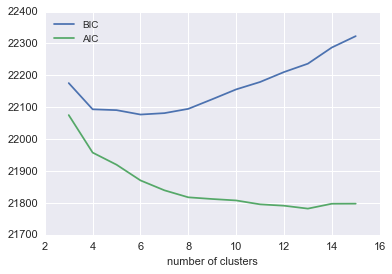

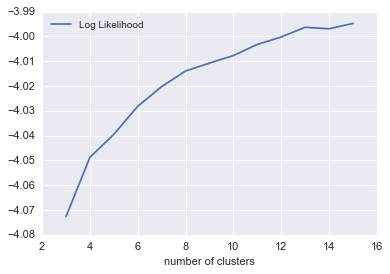

The Number of Principal Components is: 3


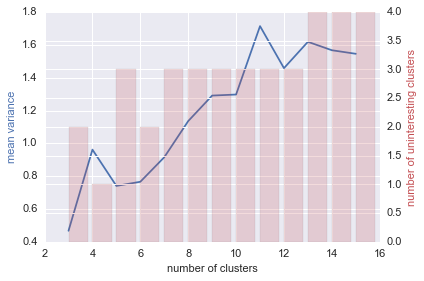

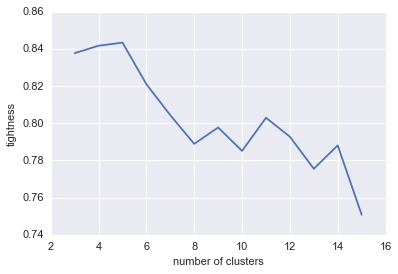

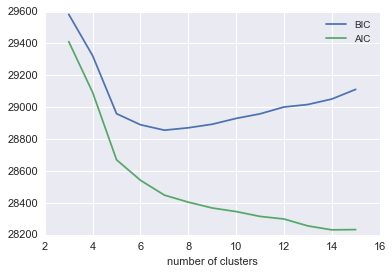

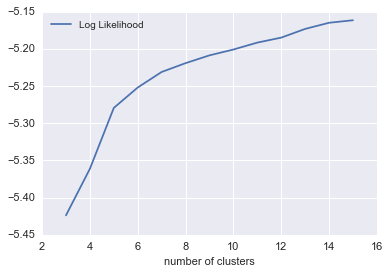

The Number of Principal Components is: 4


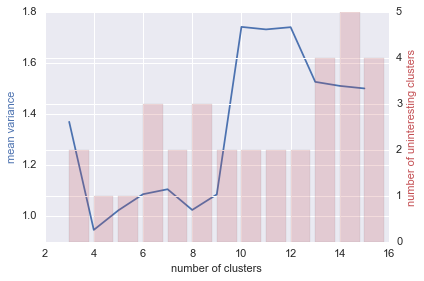

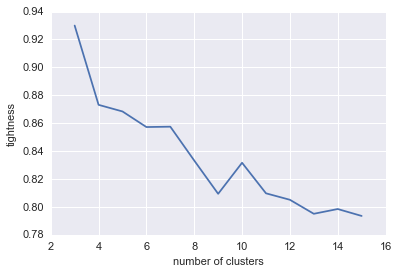

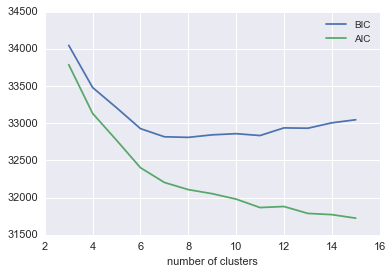

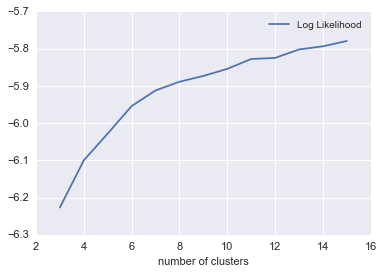

The Number of Principal Components is: 5


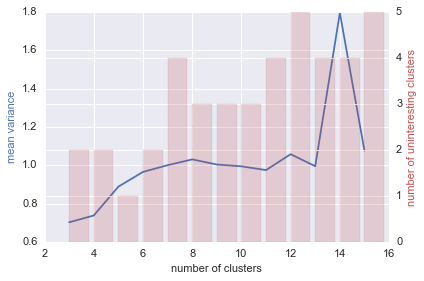

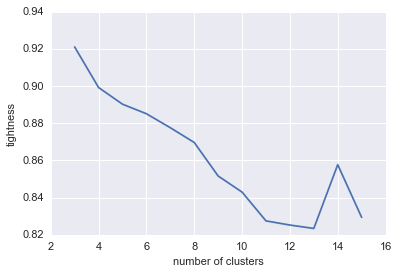

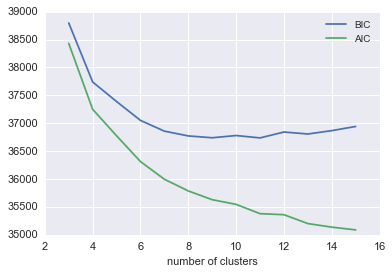

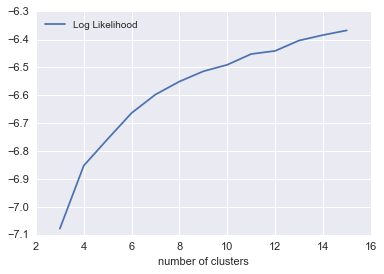

The Number of Principal Components is: 6


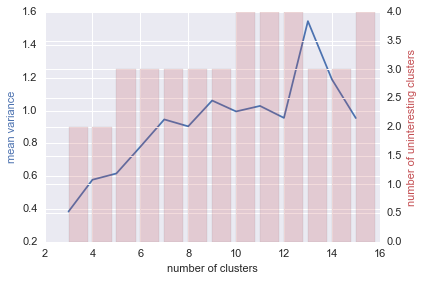

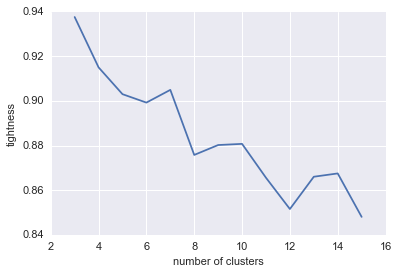

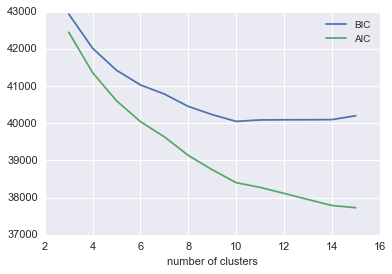

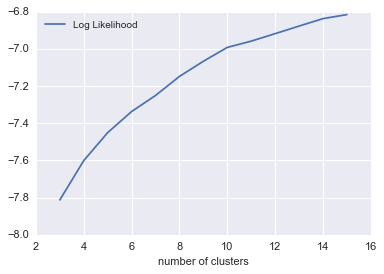

In [36]:
for i in range(2,7):
    pca = PCA(n_components=i)
    synthetic = pca.fit_transform(large_subset)
    evaluate_models(synthetic, 3, 15, i)
    

After reviewing the charts for mean variance > 1.1 and number of uninteresting clusters < 3, we have one real candidate model, 4 PCs with 7 clusters.  BIC hit's a trough at 7 clusters and the log-liklihood curve seems to have a knee at approximately 7 clusters.  Mean variance is approximately 1.1, there are 2 clusters with mean variance < 0.4.  Tightness is approximately 0.86, which is reasonable.

Also note that I ran the clustering algorithm many times with different random seeds.  The 4 component 7 cluster model was a good candidate in all runs, so I consider this a robust choice.

Below is a detailed characterization of the clusters.

Cluster 0 has the following size: 892
Cluster 0 has the following means: 
fraction_trump     0.216030
trump_premium     -0.368636
black             -0.473473
white              0.457494
hispanic_latino    0.056352
indian            -0.104547
asian              0.017736
REP                0.336638
DEM               -0.480782
UNA                0.510733
2016               0.379184
NON_NC_born        0.598165
median_age         0.196225
has_license        0.563523
dtype: float64
Cluster 0 has an average of means of: 0.136045812048
Cluster 0 has an variance of means of: 0.141100636315
Cluster 0 has a tightness of: 0.797467476254
 


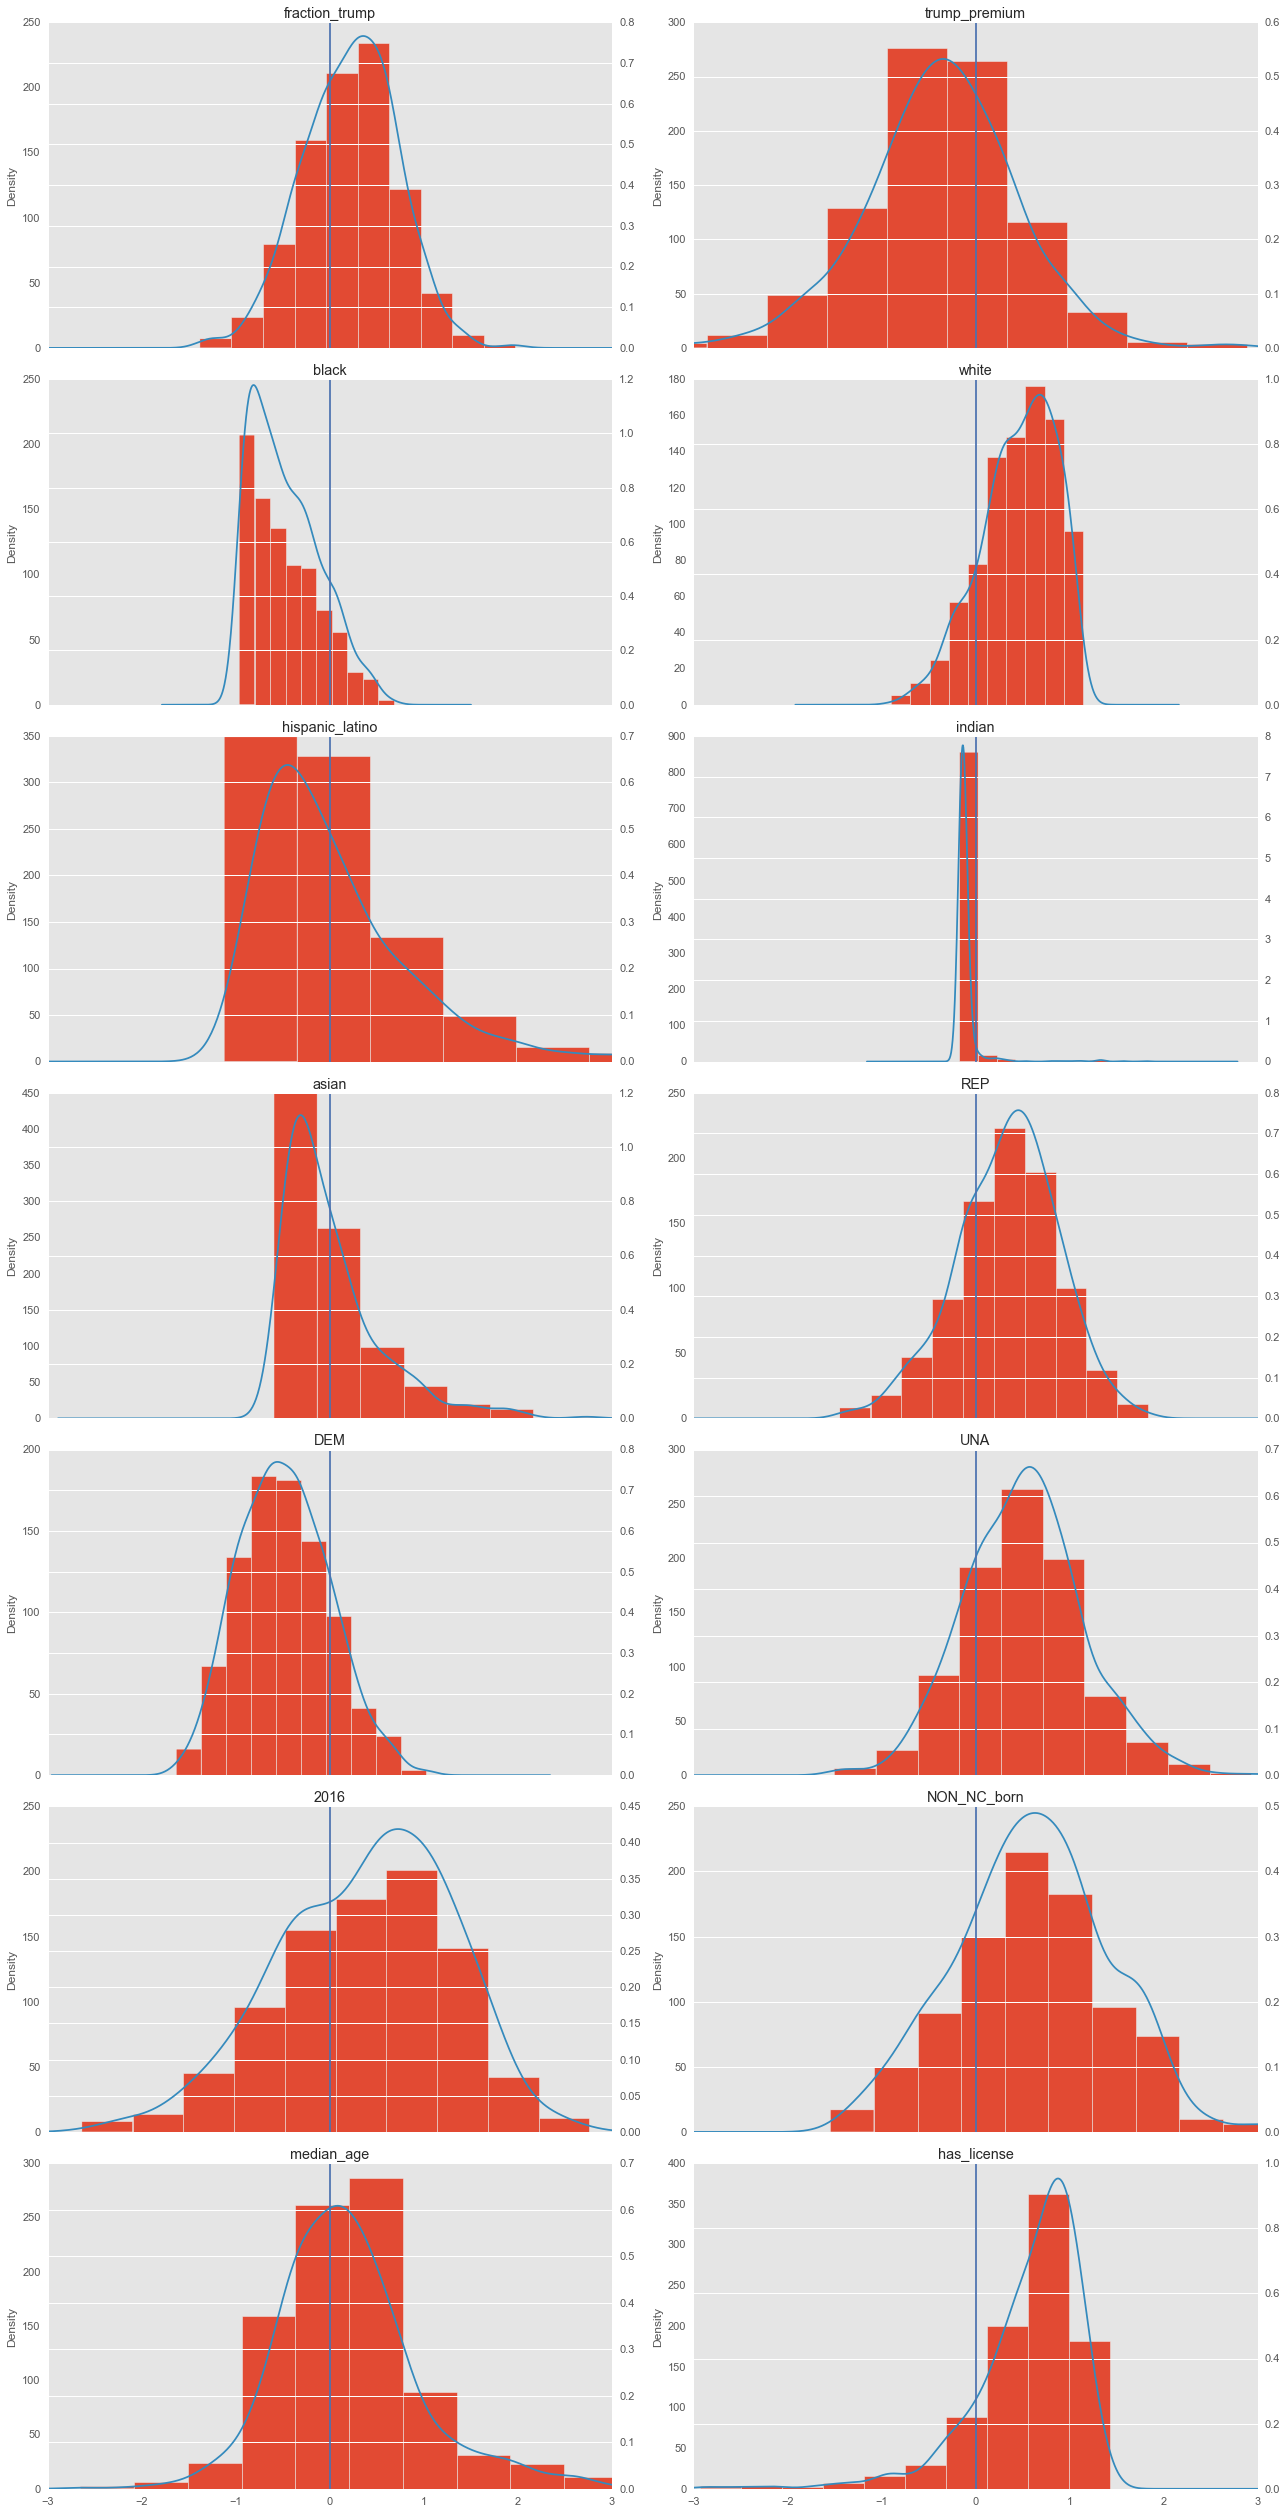

Cluster 1 has the following size: 382
Cluster 1 has the following means: 
fraction_trump    -0.919925
trump_premium     -0.756612
black              0.427755
white             -0.596713
hispanic_latino    1.017763
indian            -0.084191
asian              1.019566
REP               -0.758548
DEM                0.453945
UNA                0.414052
2016              -0.217572
NON_NC_born        0.721147
median_age        -0.873519
has_license        0.233516
dtype: float64
Cluster 1 has an average of means of: 0.00576180815969
Cluster 1 has an variance of means of: 0.490584790073
Cluster 1 has a tightness of: 0.797043322365
 


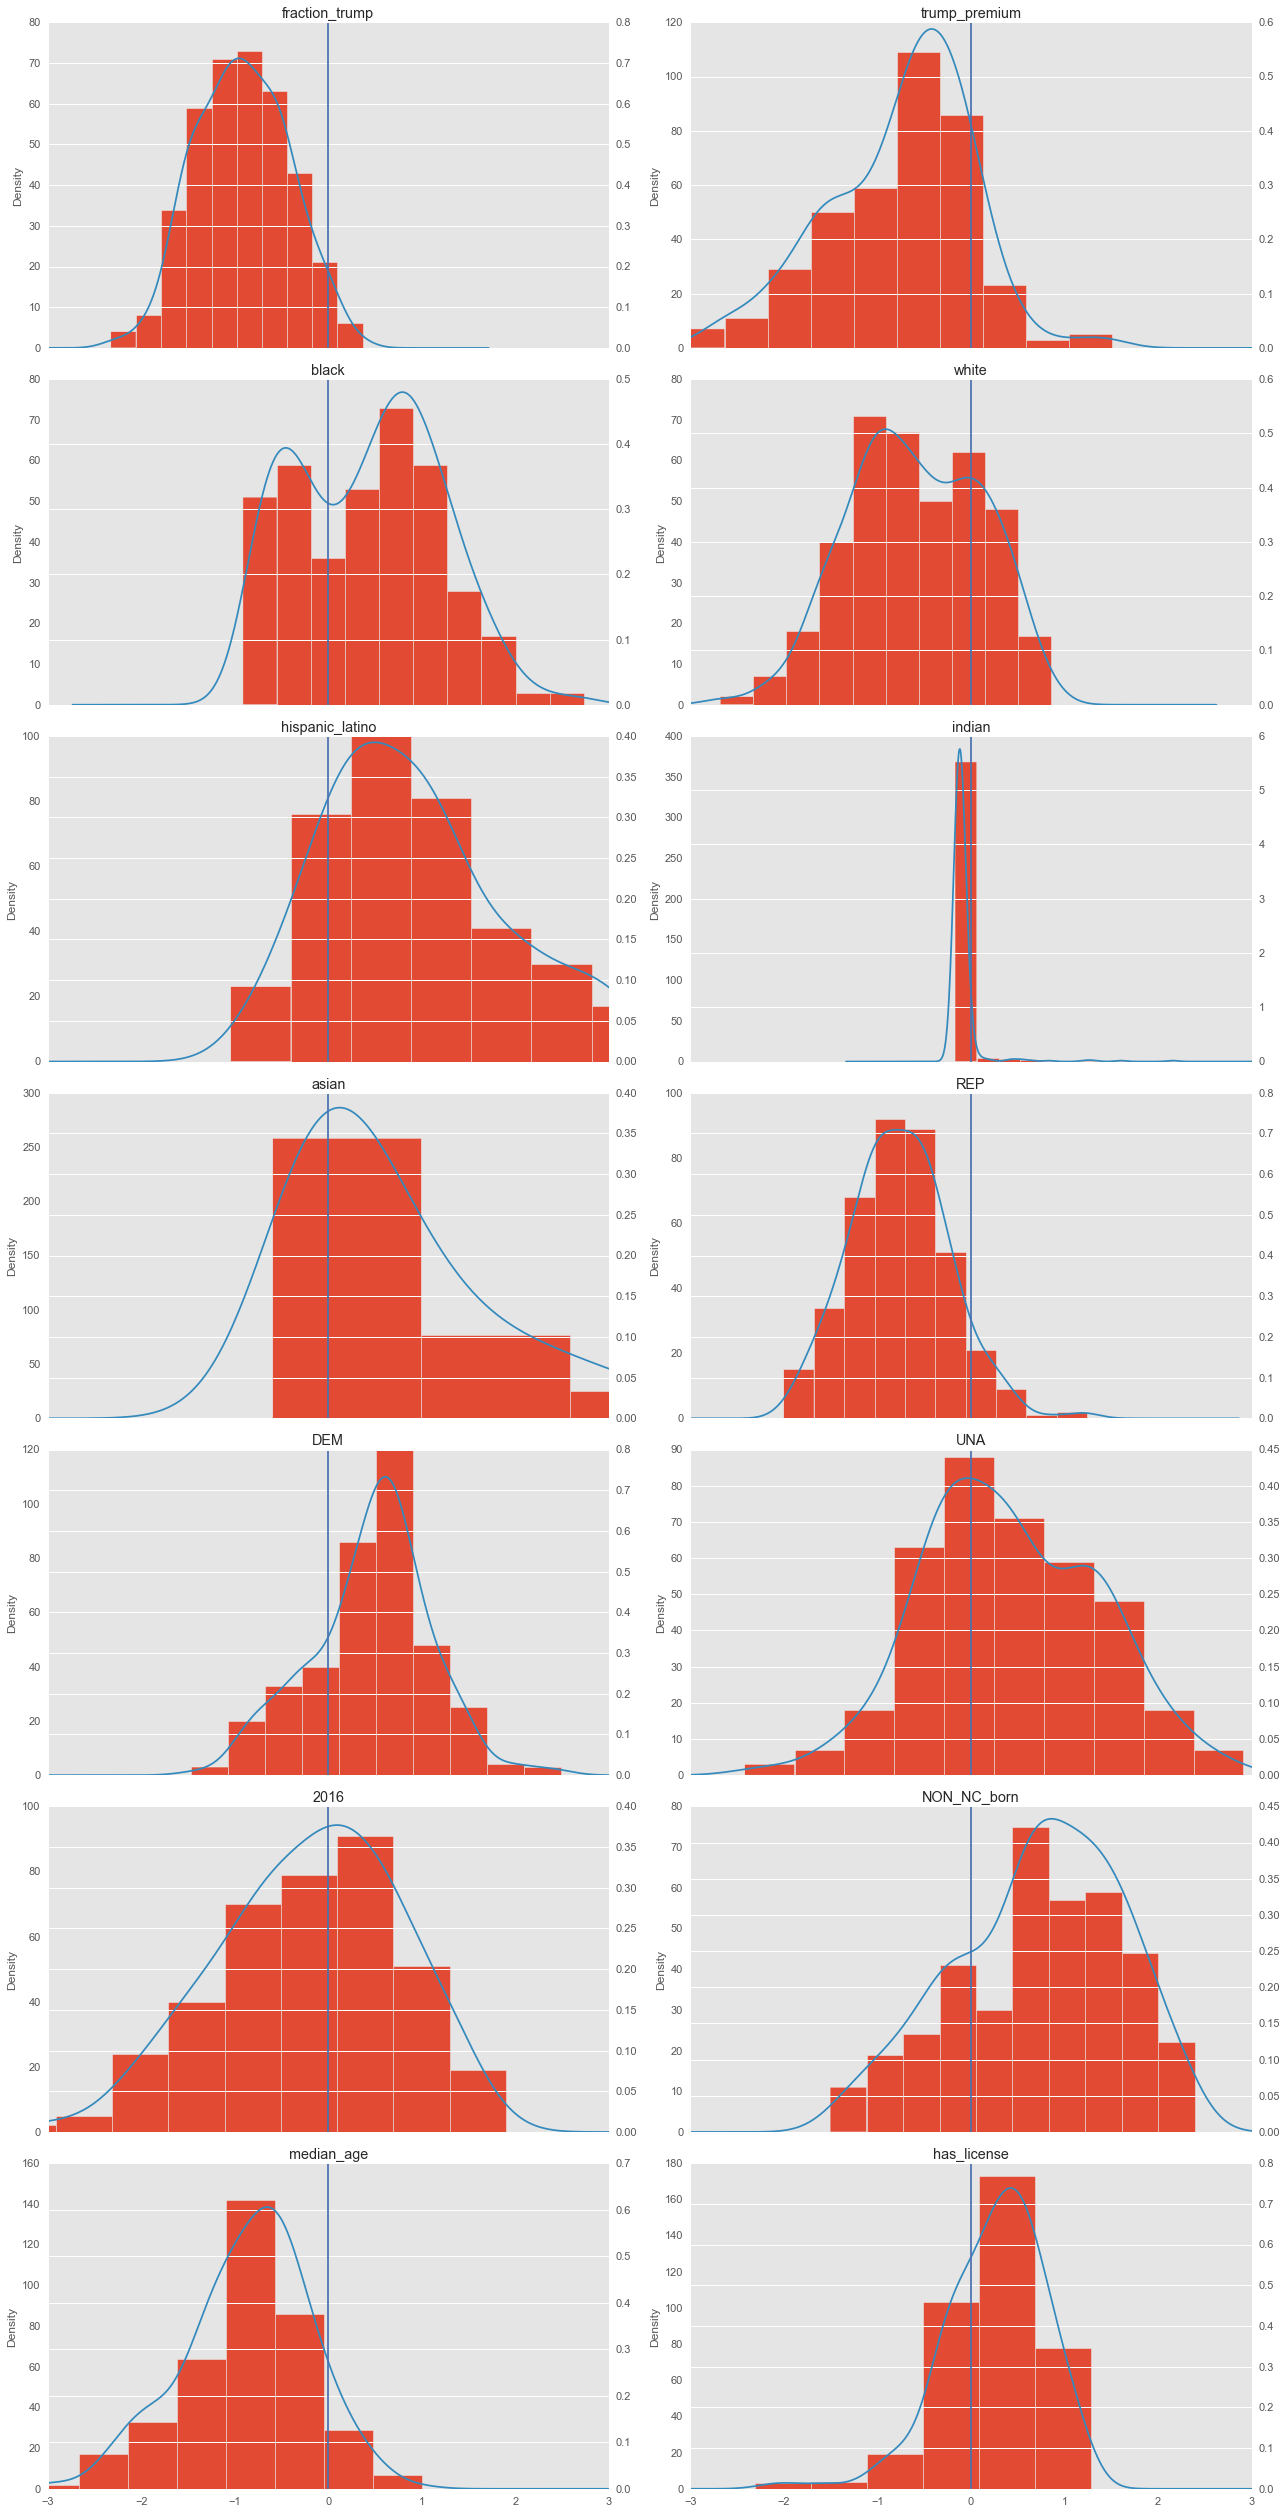

Cluster 2 has the following size: 179
Cluster 2 has the following means: 
fraction_trump    -1.969913
trump_premium     -0.444816
black              2.325016
white             -2.210679
hispanic_latino    0.606078
indian            -0.114156
asian             -0.033012
REP               -1.667059
DEM                1.859205
UNA               -1.228650
2016              -1.310880
NON_NC_born       -0.412476
median_age        -0.799727
has_license       -0.748428
dtype: float64
Cluster 2 has an average of means of: -0.43924982224
Cluster 2 has an variance of means of: 1.76038989646
Cluster 2 has a tightness of: 0.874102370036
 


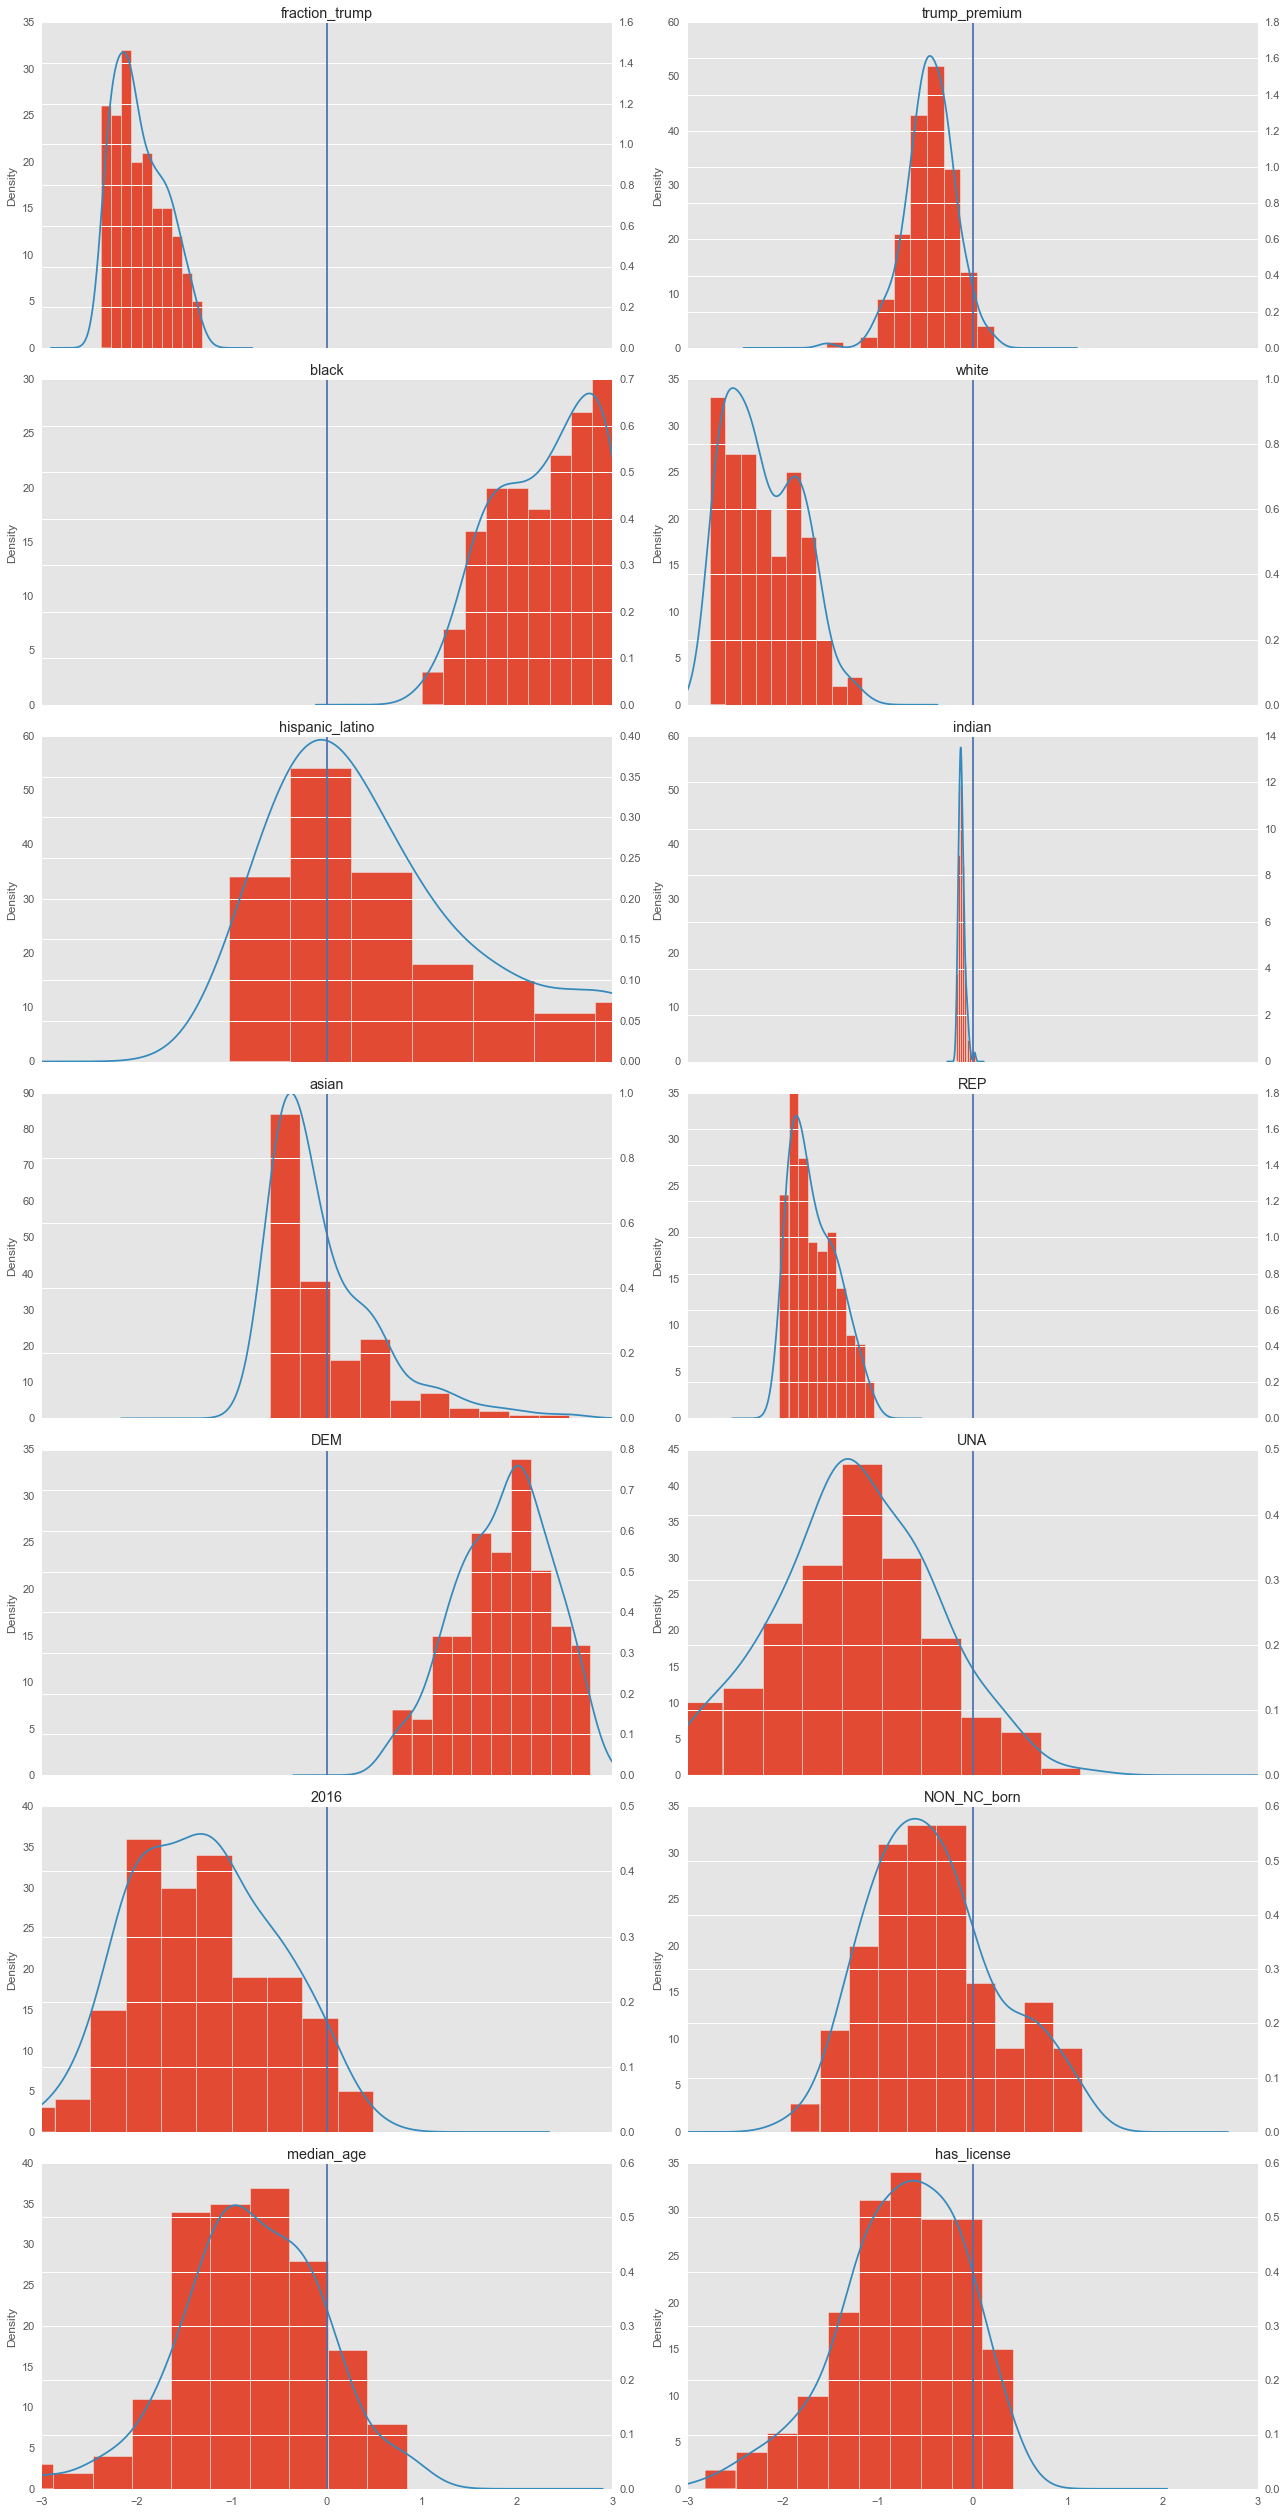

Cluster 3 has the following size: 652
Cluster 3 has the following means: 
fraction_trump     1.110001
trump_premium      0.747449
black             -0.785086
white              0.876465
hispanic_latino   -0.554221
indian            -0.130566
asian             -0.379711
REP                1.022545
DEM               -0.851049
UNA                0.033848
2016               0.330889
NON_NC_born       -0.453276
median_age         0.489720
has_license        0.078320
dtype: float64
Cluster 3 has an average of means of: 0.109666262652
Cluster 3 has an variance of means of: 0.446714124937
Cluster 3 has a tightness of: 0.829960268612
 


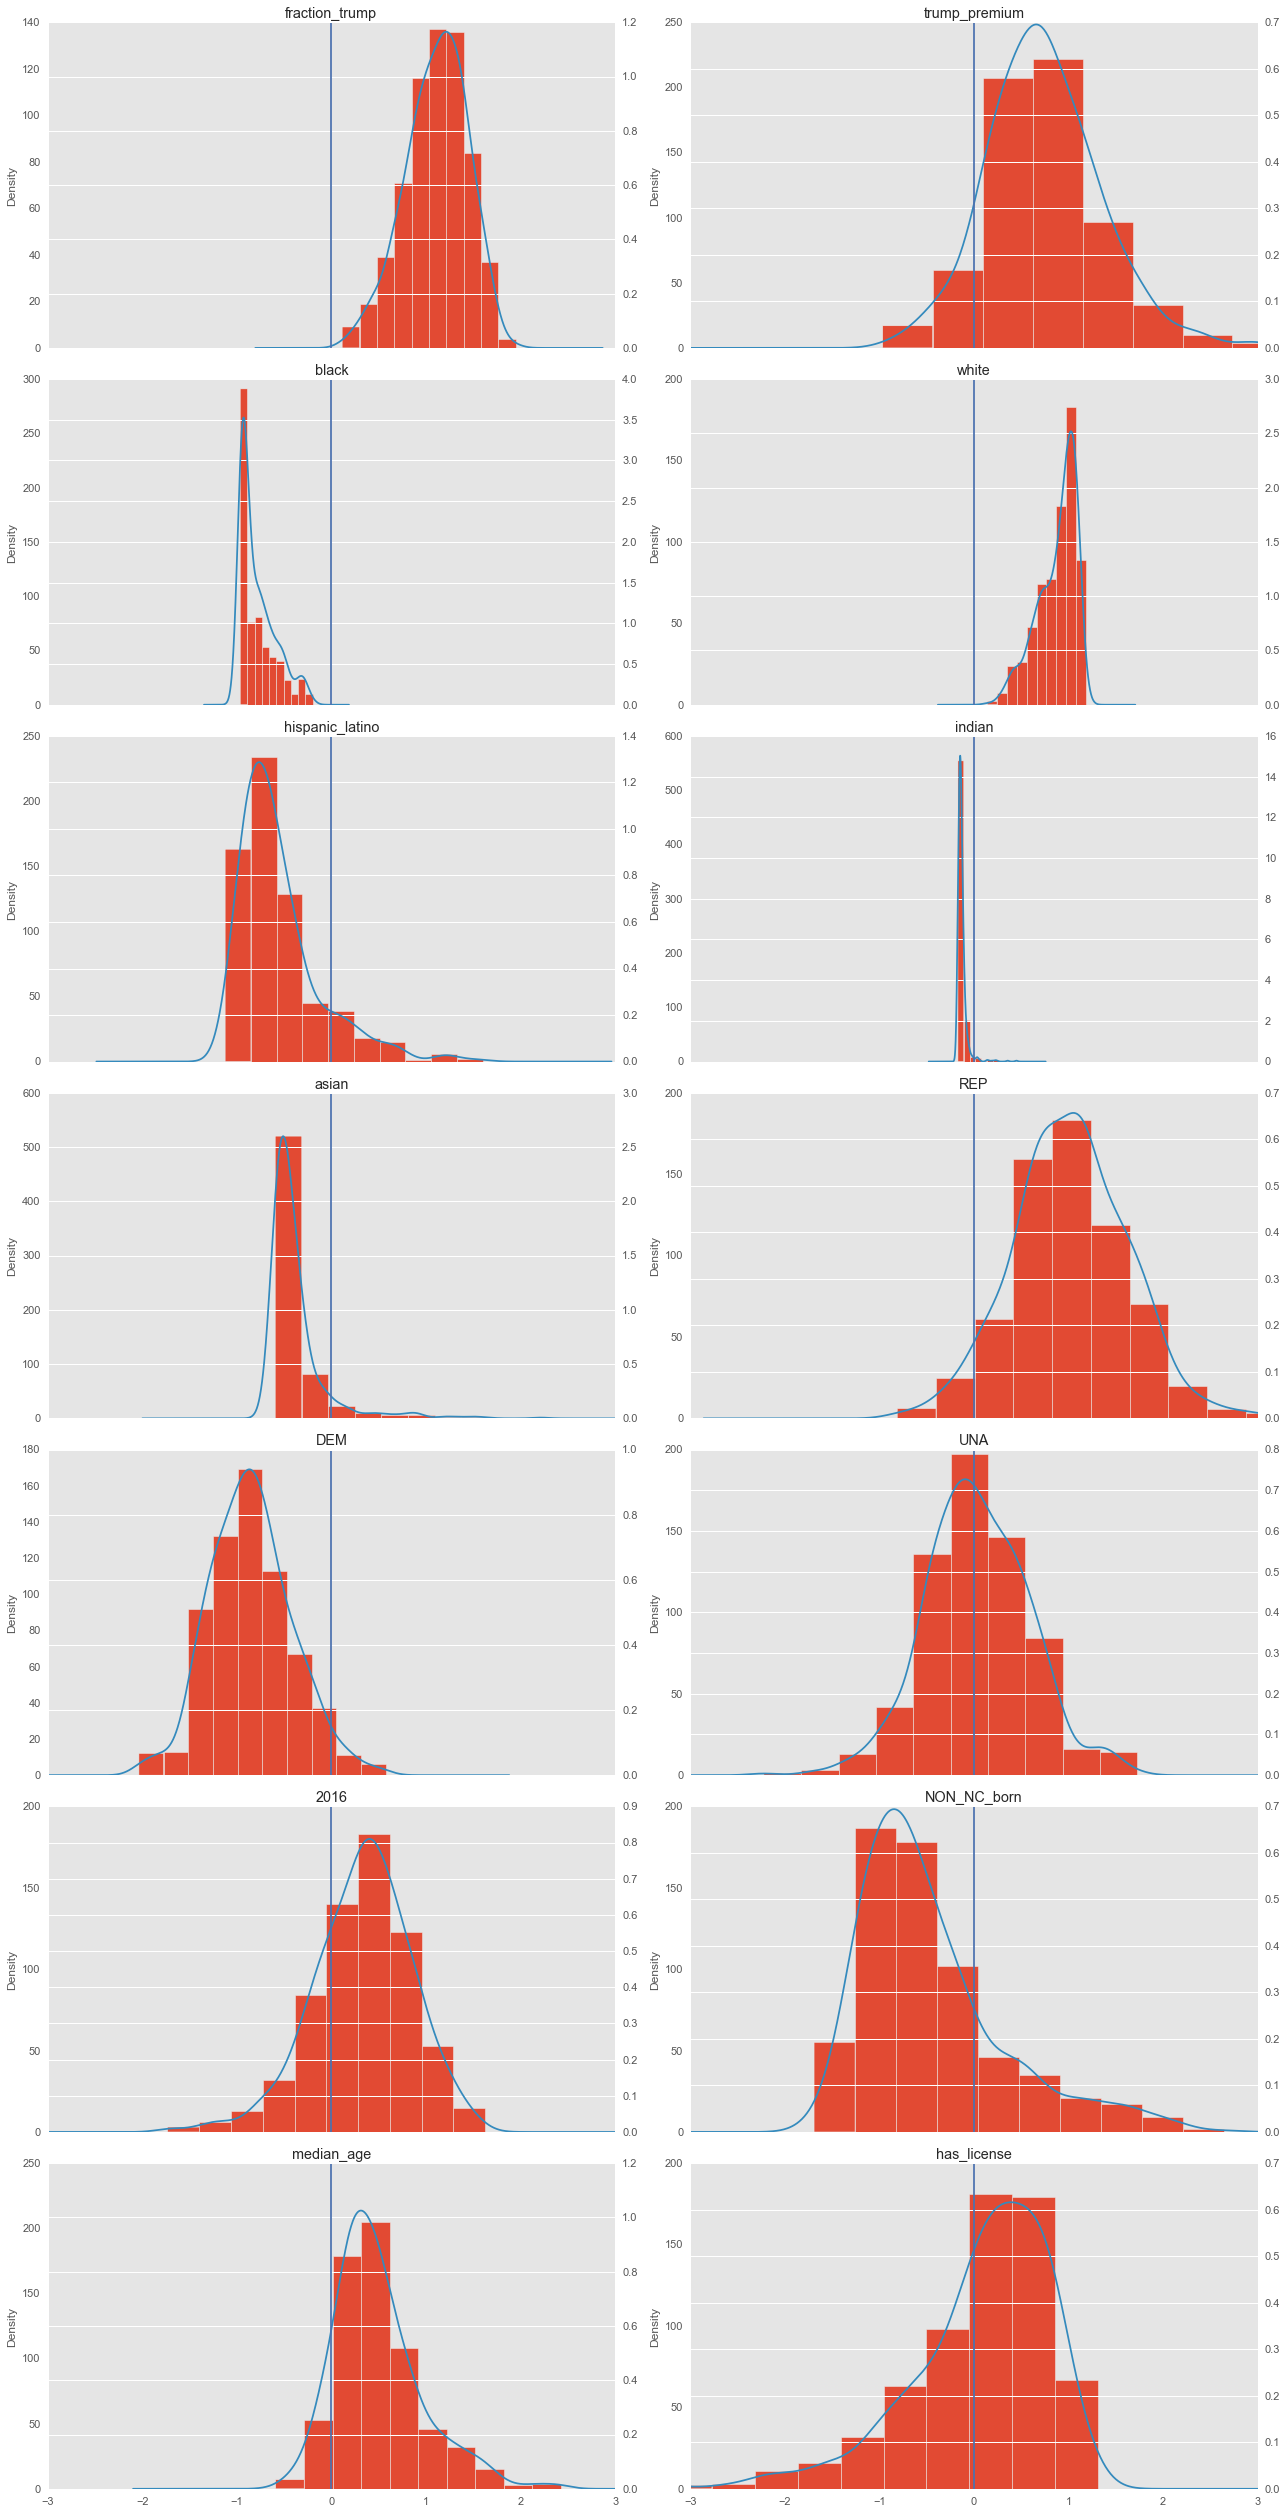

Cluster 4 has the following size: 452
Cluster 4 has the following means: 
fraction_trump    -0.002080
trump_premium      0.496787
black              0.723887
white             -0.538160
hispanic_latino   -0.518668
indian            -0.107433
asian             -0.444536
REP               -0.522378
DEM                0.851986
UNA               -1.050987
2016              -0.038131
NON_NC_born       -0.922905
median_age         0.433895
has_license       -0.580203
dtype: float64
Cluster 4 has an average of means of: -0.158494548249
Cluster 4 has an variance of means of: 0.35910423154
Cluster 4 has a tightness of: 0.839552711348
 


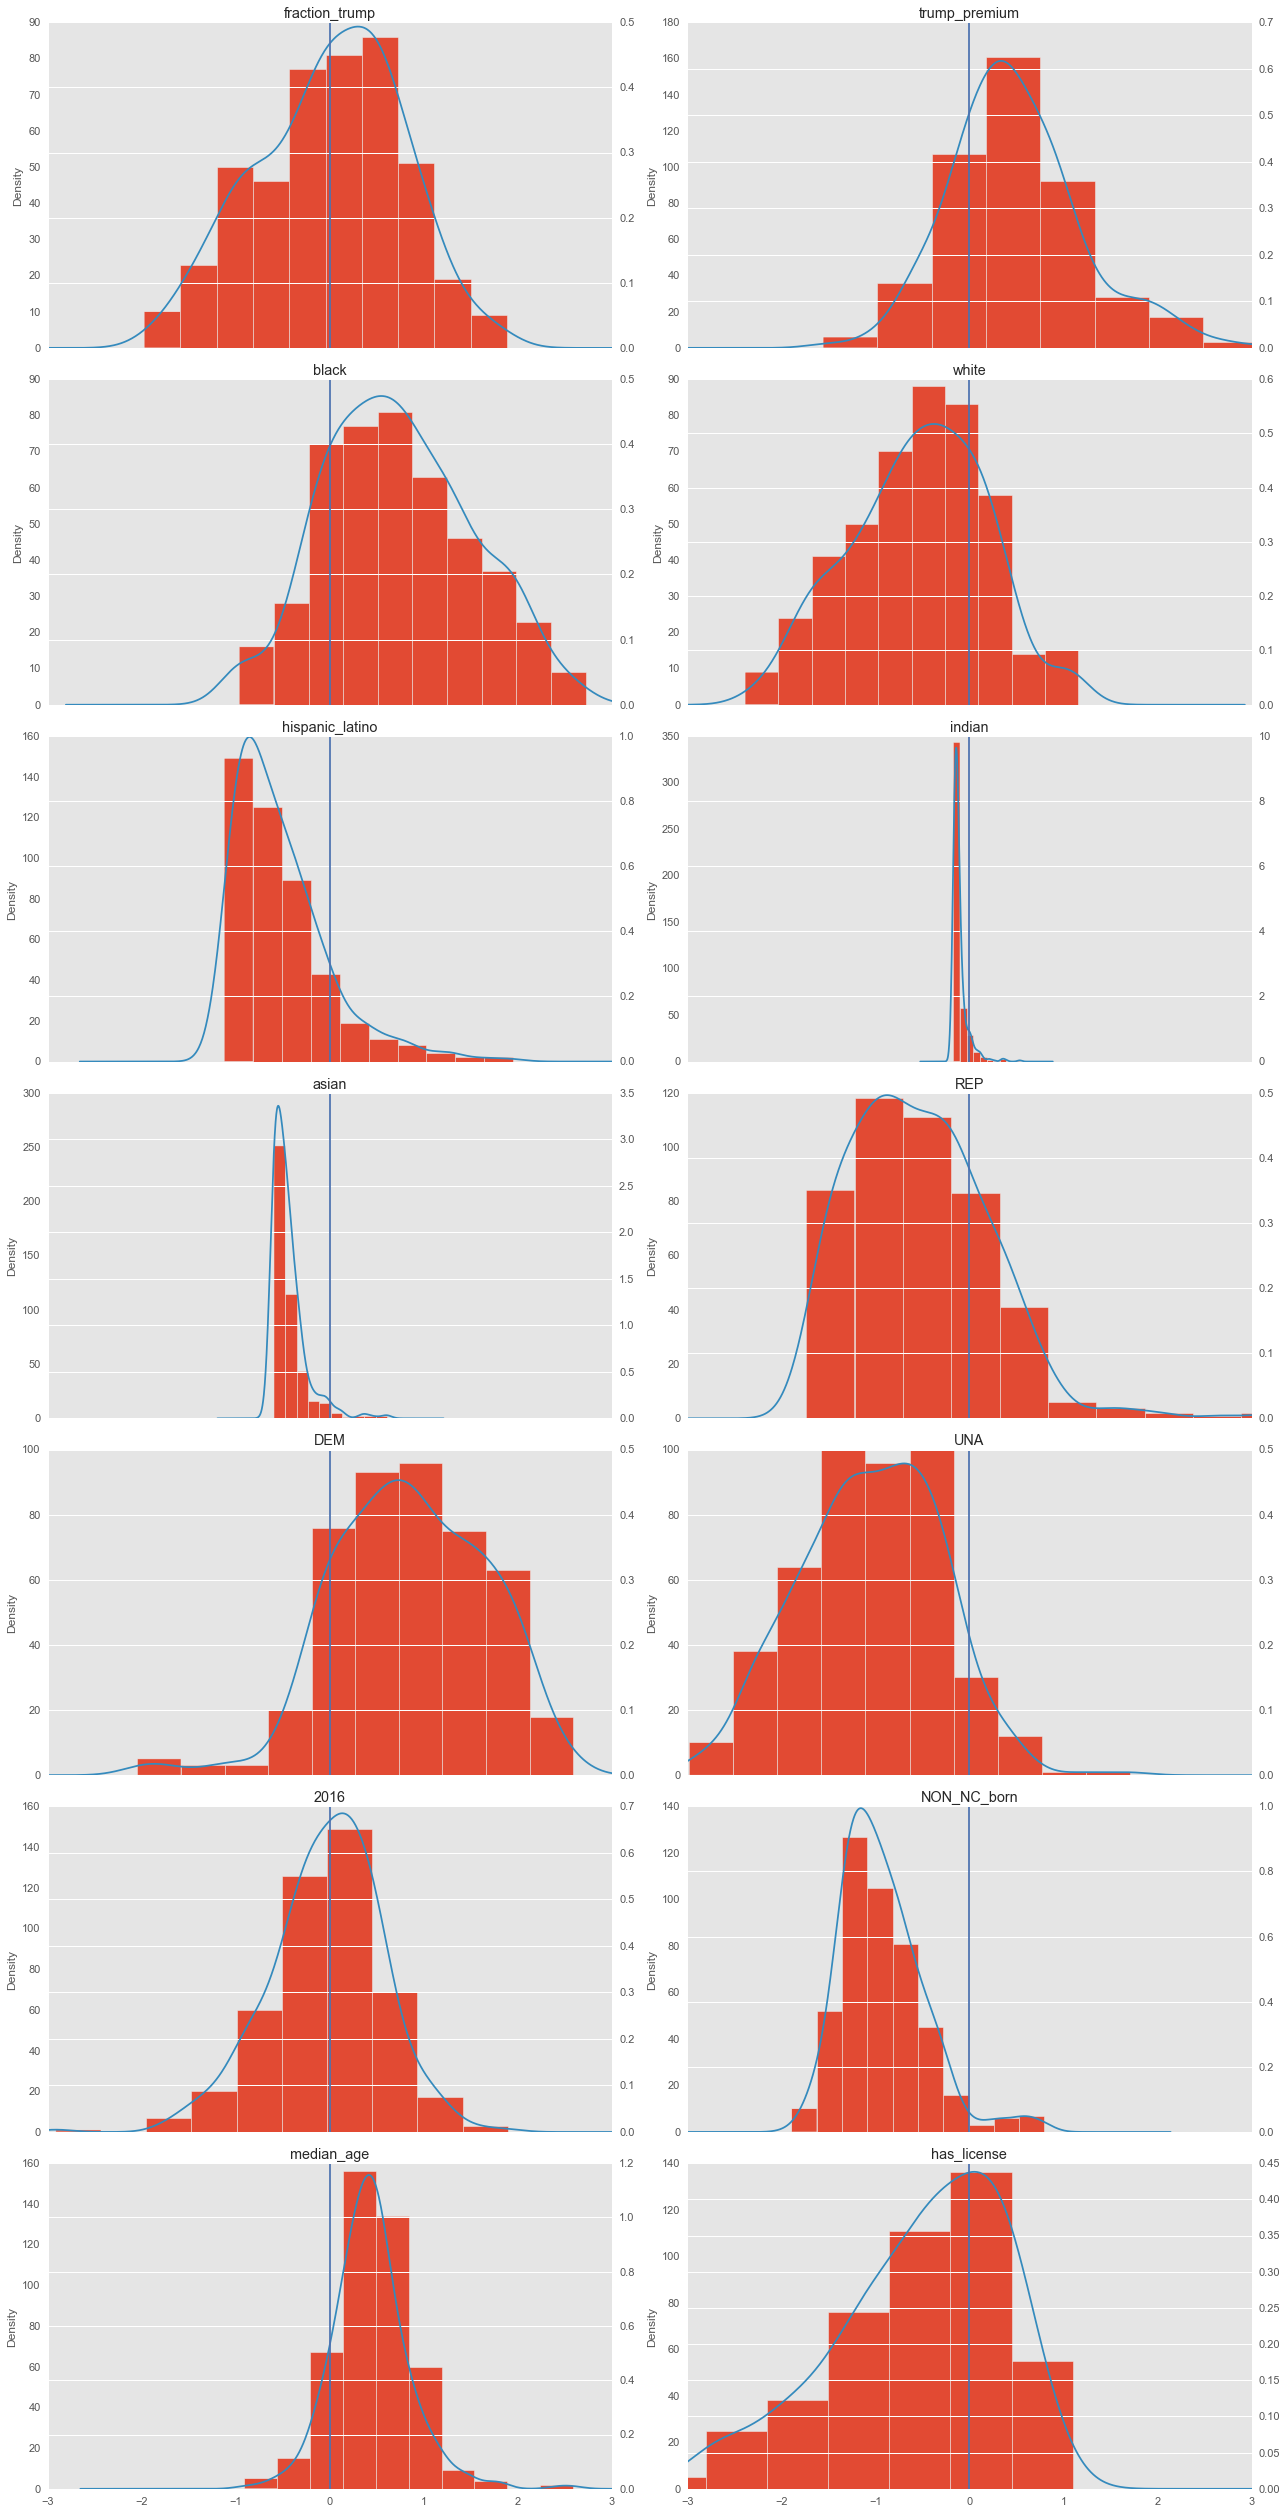

Cluster 5 has the following size: 55
Cluster 5 has the following means: 
fraction_trump     0.227829
trump_premium      2.203716
black              0.111445
white             -1.244901
hispanic_latino   -0.397619
indian             5.261252
asian             -0.365336
REP               -1.074393
DEM                1.283586
UNA               -0.996857
2016              -1.608564
NON_NC_born       -1.296827
median_age        -0.075693
has_license       -1.673245
dtype: float64
Cluster 5 has an average of means of: 0.0253136765455
Cluster 5 has an variance of means of: 3.48493825052
Cluster 5 has a tightness of: 0.971069420877
 


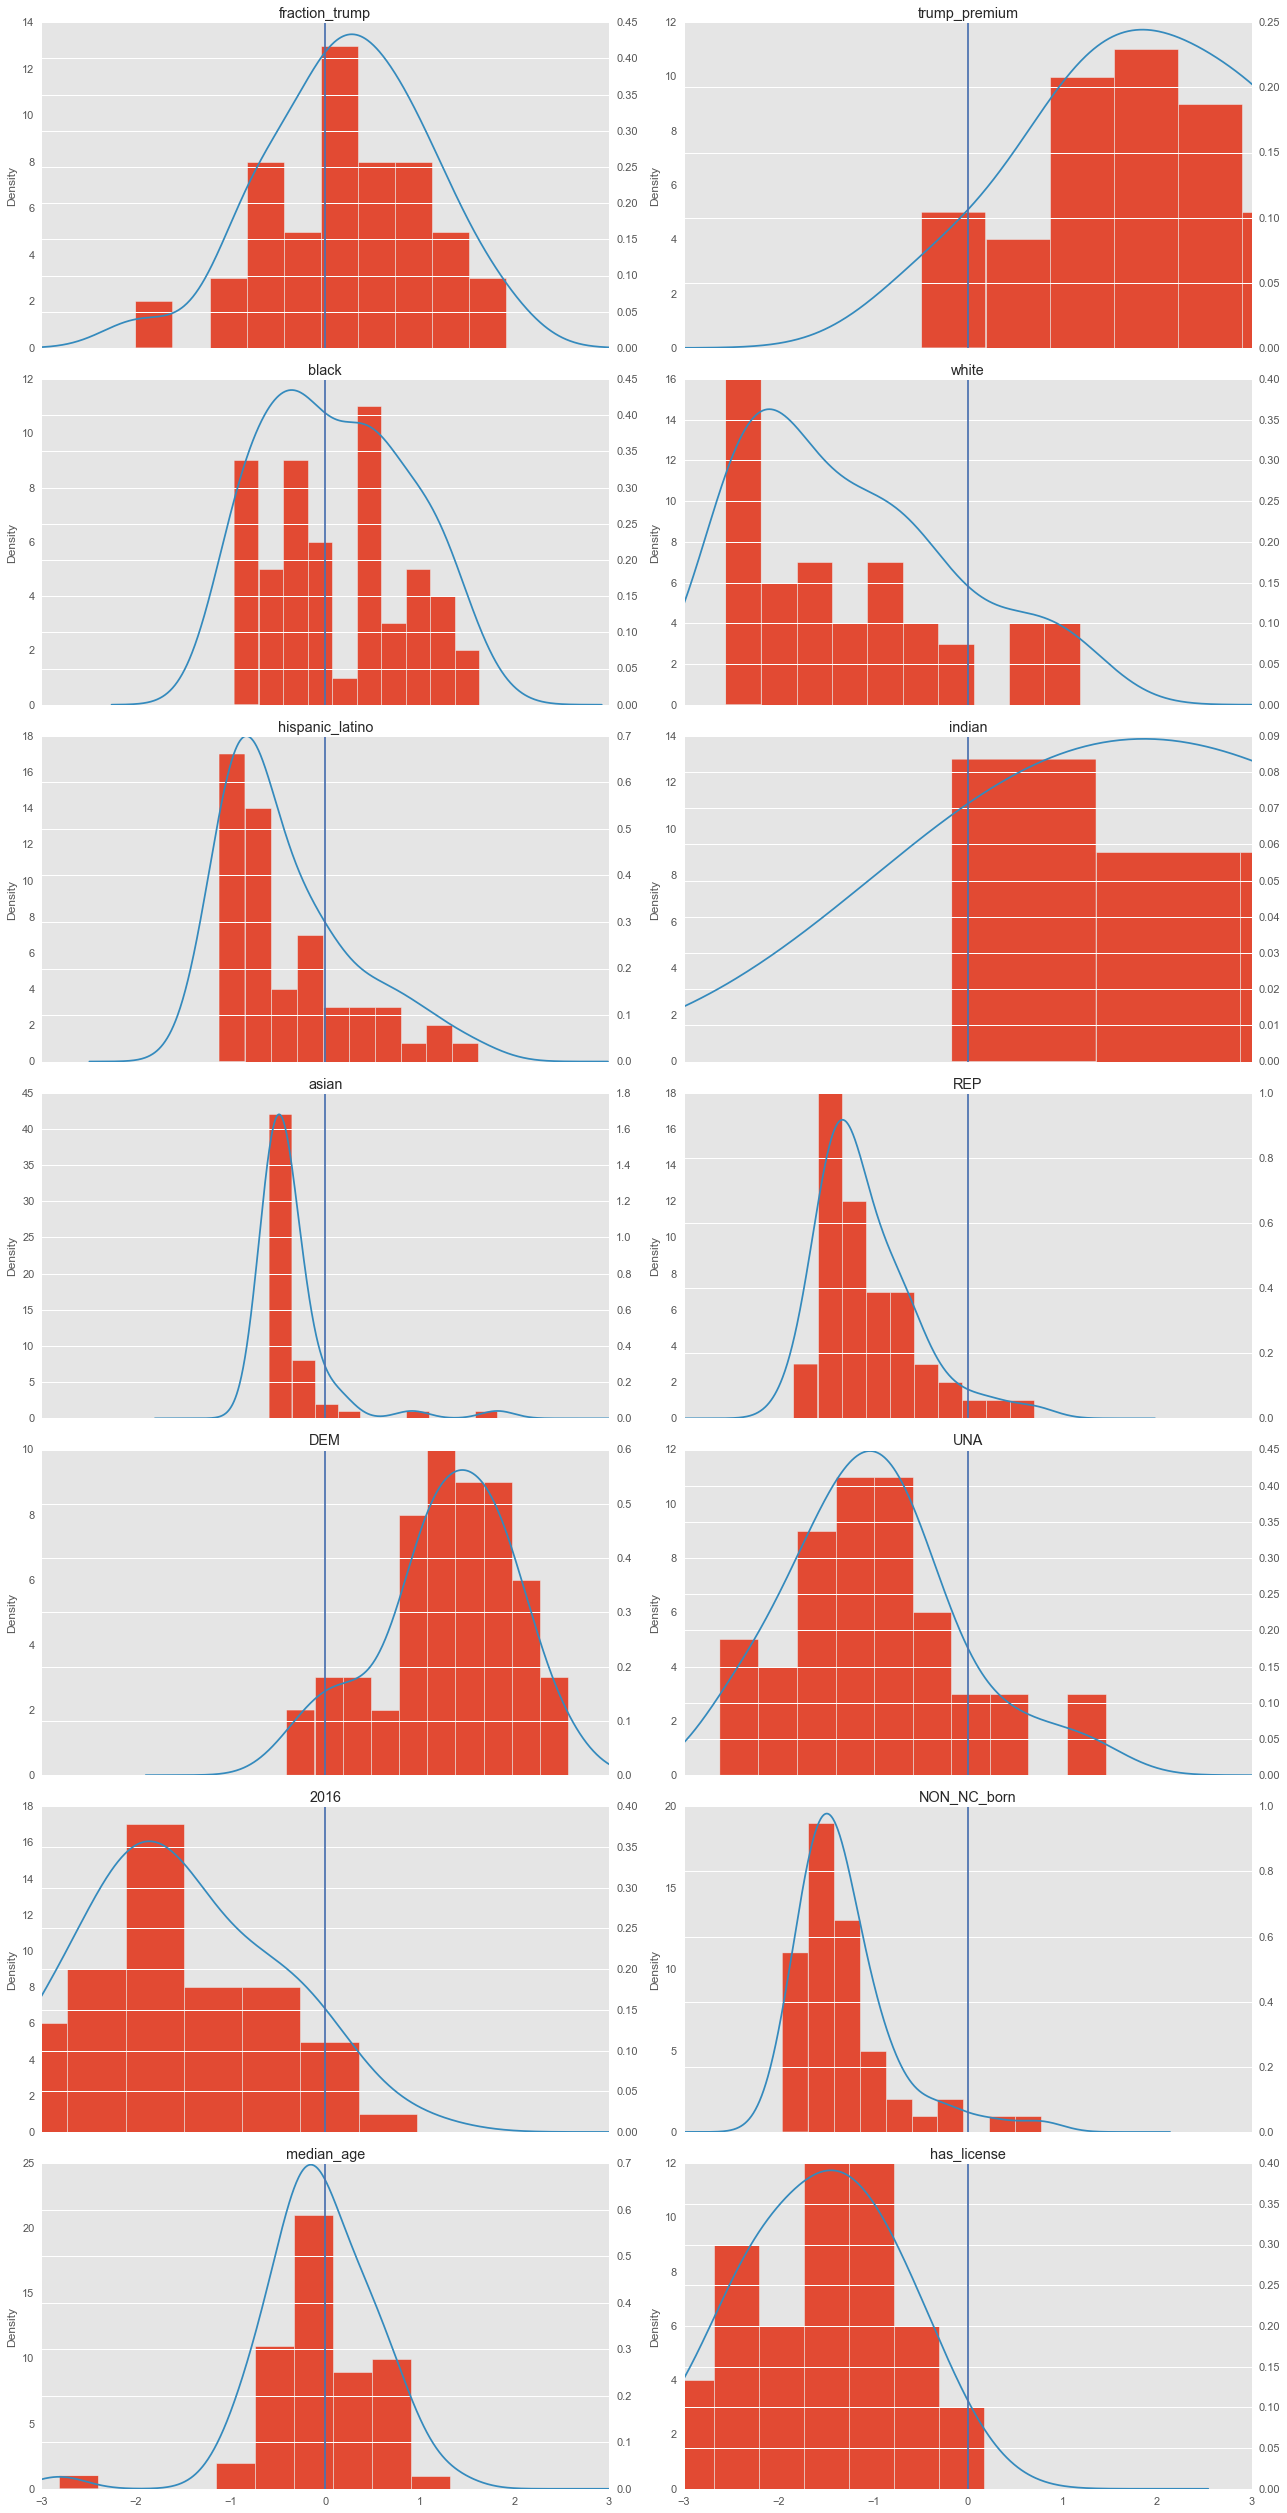

Cluster 6 has the following size: 94
Cluster 6 has the following means: 
fraction_trump    -1.082031
trump_premium     -0.885588
black              0.226674
white             -0.469850
hispanic_latino    0.745957
indian            -0.104567
asian              0.736268
REP               -0.889416
DEM                0.232356
UNA                1.212672
2016              -1.406924
NON_NC_born        0.519219
median_age        -2.228218
has_license       -1.645549
dtype: float64
Cluster 6 has an average of means of: -0.359928402361
Cluster 6 has an variance of means of: 1.05849457781
Cluster 6 has a tightness of: 0.893322188433
 


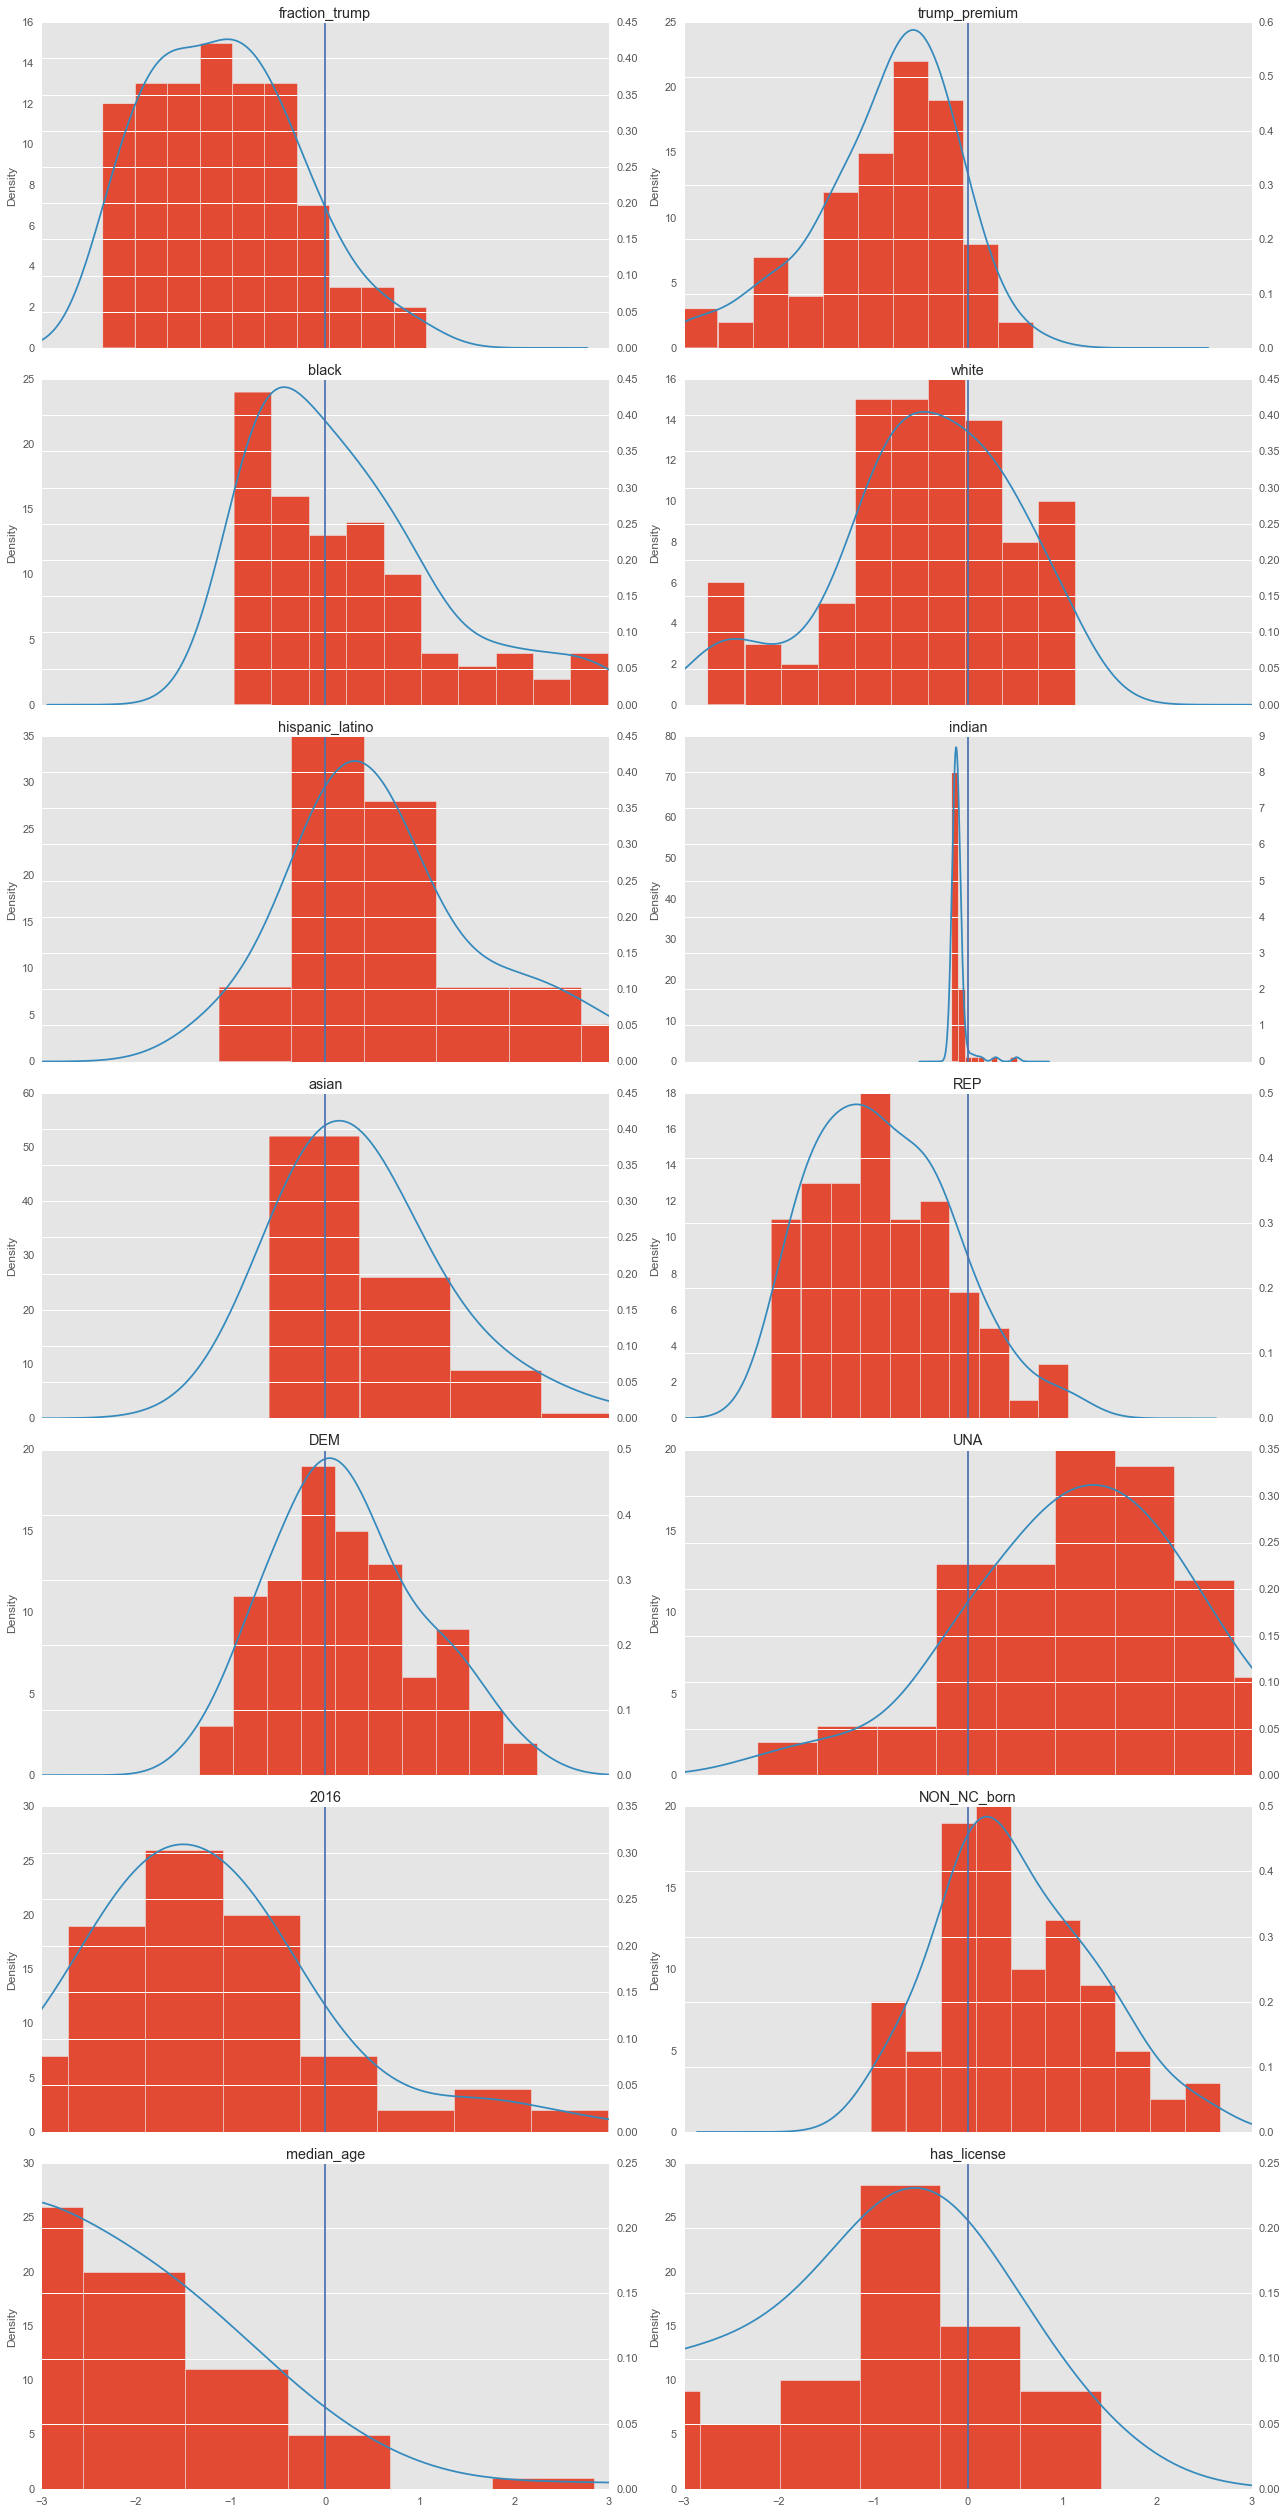

The avearage variance of the clusters is: 1.10590378681
The number of uninteresting clusters is: 2
The average tightness of the clusters is: 0.857502536846


(1.1059037868067054, 2, 0.8575025368464448)

In [37]:
pca = PCA(n_components=4) #four components
synthetic = pca.fit_transform(large_subset)
clusters, model, standardized_data_clusters = pct_cluster(synthetic, standardized_data, num_clusters=7) #seven clusters
dummy, dummy, raw_data_clusters = pct_cluster(synthetic, raw_data, num_clusters=7)
characterize_interest(clusters, feature_set, True)

We now have two dataframes with this clustering information, raw_data_clusters and standardized_data_clusters. First, let's save these to csv files.  

In [38]:
raw_data_clusters.to_csv('raw_data_clusters2.csv')
standardized_data_clusters.to_csv('standardized_data_clusters2.csv')

Let's note that after viewing these files, we note that Wake 16-10 and 16-11 have been assigned to cluster 1.  Therefore, we will manually assign precinct Wake 16-08 to cluster 1.  Wake 19-18 and 19-19 have been assigned to cluster 0 , so we will assign Wake 19-10 to cluster 0.

Next, to visualize the clustering and other characteristics of the precincts, we will read in a geojson file containing the geometry of the features and 2016 presidential election voting. 

In [39]:
nc_map = gpd.read_file('pres2016precincts.geojson')

Let's see how many precincts are in each dataframe/geodataframe. 

In [40]:
len(nc_map), len(raw_data_clusters)

(2704, 2706)

This makes sense. 'nc_map' has 2 precincts that are not in the cluster dataframes.  But the cluster dataframes have 4 precincts that are not in 'nc_map'.  This accounts for the differnences.

Now we do a left join of both the raw and standardized dataframes to the geodataframe.  We will then manually assign the cluster values described above to the resulting  geodataframe.

First, we need to add the key field 'county_pct' to the geodataframe.  We form this new column by concatenating county name and precinct name.

In [41]:
nc_map.loc[ : ,'county_pct'] = nc_map['COUNTY_NAM'].map(str) + nc_map['PREC_ID'].map(str)
nc_map.loc[ : ,'county_pct'] = nc_map['county_pct'].apply(strip_blanks)

In [42]:
raw_nc_map = nc_map.merge(raw_data_clusters, on='county_pct', how='left')
standardized_nc_map = nc_map.merge(standardized_data_clusters, on='county_pct', how='left')

Now we fix WAKE16-08 and WAKE19-10

In [43]:
raw_nc_map.loc[raw_nc_map['county_pct']=='WAKE16-08', 'cluster']=1
raw_nc_map.loc[raw_nc_map['county_pct']=='WAKE19-10', 'cluster']=0
standardized_nc_map.loc[standardized_nc_map['county_pct']=='WAKE16-08', 'cluster']=1
standardized_nc_map.loc[standardized_nc_map['county_pct']=='WAKE19-10', 'cluster']=0

Let's set up two functions.  cluster_definitions returns a 'cluster name' based upon the cluster number.  cluster_colors returns a color code based upon the cluster number.

In [44]:
def cluster_definitions(x):
    if x == 0.0:
        return 'White, Balanced'
    elif x == 1.0:
        return 'Diverse, Balanced'
    elif x == 2.0:
        return 'Discouraged African Americans'
    elif x == 3.0:
        return 'Passionate Whites'
    elif x == 4.0:
        return 'Maybe-Trump Democrats'
    elif x == 5.0:
        return 'Discouraged Native Americans'
    elif x == 6.0:
        return 'Soldiers and Students'
    else:
        return 'No Cluster'
    #return cluster_names[x]

In [45]:
def cluster_colors(x):
    if x == 0.0:
        return '#ffff00' #yellow
    elif x == 1.0:
        return '#00ffff' #cyan
    elif x == 2.0:
        return '#0000ff' #blue
    elif x == 3.0:
        return '#ff0000' #red
    elif x == 4.0:
        return '#ee82ee' #voilet
    elif x == 5.0:
        return '#ffa500' #orange
    elif x == 6.0:
        return '#00ff00' #green
    else:
        return '#ffffff' #white

Now we add cluster defintions

In [46]:
raw_nc_map.loc[ : ,'cluster_definition'] = raw_nc_map['cluster'].apply(cluster_definitions)
raw_nc_map = raw_nc_map[raw_nc_map['cluster_definition']!='No Cluster']

Now we add cluster colors

In [47]:
raw_nc_map.loc[ : ,'cluster_color'] = raw_nc_map['cluster'].apply(cluster_colors)
raw_nc_map = raw_nc_map[raw_nc_map['cluster_color']!='#ffffff']

Let's add some descriptive information

In [48]:
raw_nc_map.loc[:,'white'] = raw_nc_map.apply(lambda x: round(x['white'],2), axis=1)
raw_nc_map.loc[:,'white'] = raw_nc_map['white'].astype(str)
raw_nc_map.loc[:,'black'] = raw_nc_map.apply(lambda x: round(x['black'],2), axis=1)
raw_nc_map.loc[:,'black'] = raw_nc_map['black'].astype(str)
raw_nc_map.loc[:,'asian'] = raw_nc_map.apply(lambda x: round(x['asian'],2), axis=1)
raw_nc_map.loc[:,'asian'] = raw_nc_map['asian'].astype(str)
raw_nc_map.loc[:,'indian'] = raw_nc_map.apply(lambda x: round(x['indian'],2), axis=1)
raw_nc_map.loc[:,'indian'] = raw_nc_map['indian'].astype(str)
raw_nc_map.loc[:,'hispanic_latino'] = raw_nc_map.apply(lambda x: round(x['hispanic_latino'],2), axis=1)
raw_nc_map.loc[:,'hispanic_latino'] = raw_nc_map['hispanic_latino'].astype(str)
raw_nc_map.loc[:,'fraction_trump'] = raw_nc_map.apply(lambda x: round(x['fraction_trump'],2), axis=1)
raw_nc_map.loc[:,'fraction_trump'] = raw_nc_map['fraction_trump'].astype(str)
raw_nc_map.loc[:,'fraction_newton'] = raw_nc_map.apply(lambda x: round(x['fraction_newton'],2), axis=1)
raw_nc_map.loc[:,'fraction_newton'] = raw_nc_map['fraction_newton'].astype(str)
raw_nc_map.loc[:,'2016'] = raw_nc_map.apply(lambda x: round(x['2016'],2), axis=1)
raw_nc_map.loc[:,'2016'] = raw_nc_map['2016'].astype(str)
raw_nc_map.loc[:,'REP'] = raw_nc_map.apply(lambda x: round(x['REP'],2), axis=1)
raw_nc_map.loc[:,'REP'] = raw_nc_map['REP'].astype(str)
raw_nc_map.loc[:,'DEM'] = raw_nc_map.apply(lambda x: round(x['DEM'],2), axis=1)
raw_nc_map.loc[:,'DEM'] = raw_nc_map['DEM'].astype(str)
raw_nc_map.loc[:,'UNA'] = raw_nc_map.apply(lambda x: round(x['UNA'],2), axis=1)
raw_nc_map.loc[:,'UNA'] = raw_nc_map['UNA'].astype(str)
raw_nc_map.loc[:,'median_age'] = raw_nc_map.apply(lambda x: round(x['median_age'],0), axis=1)
raw_nc_map.loc[:,'median_age'] = raw_nc_map['median_age'].astype(str)
raw_nc_map.loc[:,'cluster_strength'] = raw_nc_map.apply(lambda x: round(x['cluster_strength'],2), axis=1)
raw_nc_map.loc[:,'cluster_strength'] = raw_nc_map['cluster_strength'].astype(str)

In [49]:
raw_nc_map.loc[:,'popup'] = ('County: ' + raw_nc_map.loc[:,'COUNTY_NAM'] + 
                             '<br>Precinct: ' + raw_nc_map.loc[:,'PREC_ID'] + 
                             '<br>Cluster: ' +  raw_nc_map.loc[:,'cluster_definition'] + 
                             '<br>Cluster Strength: ' +  raw_nc_map.loc[:,'cluster_strength'] +
                             '<br>Fraction White: ' + raw_nc_map['white'] +  
                             '<br>Fraction African American: ' + raw_nc_map['black'] + 
                             '<br>Fraction Asian: ' + raw_nc_map['asian'] + 
                             '<br>Fraction Native American: ' + raw_nc_map['indian'] + 
                             '<br>Fraction Histanic Latino: ' + raw_nc_map['hispanic_latino'] + 
                             '<br>Median Age: ' + raw_nc_map['median_age'] +
                             '<br>Fraction Trump: ' + raw_nc_map['fraction_trump'] +
                             '<br>Fraction Newton: ' + raw_nc_map['fraction_newton'] +
                             '<br>2016 Turnout: ' + raw_nc_map['2016'] + 
                             '<br>Fraction Repbulican: ' + raw_nc_map['REP'] + 
                             '<br>Fraction Democarat: ' + raw_nc_map['DEM'] + 
                             '<br>Fraction Unaffiliated: ' + raw_nc_map['UNA'])
                            

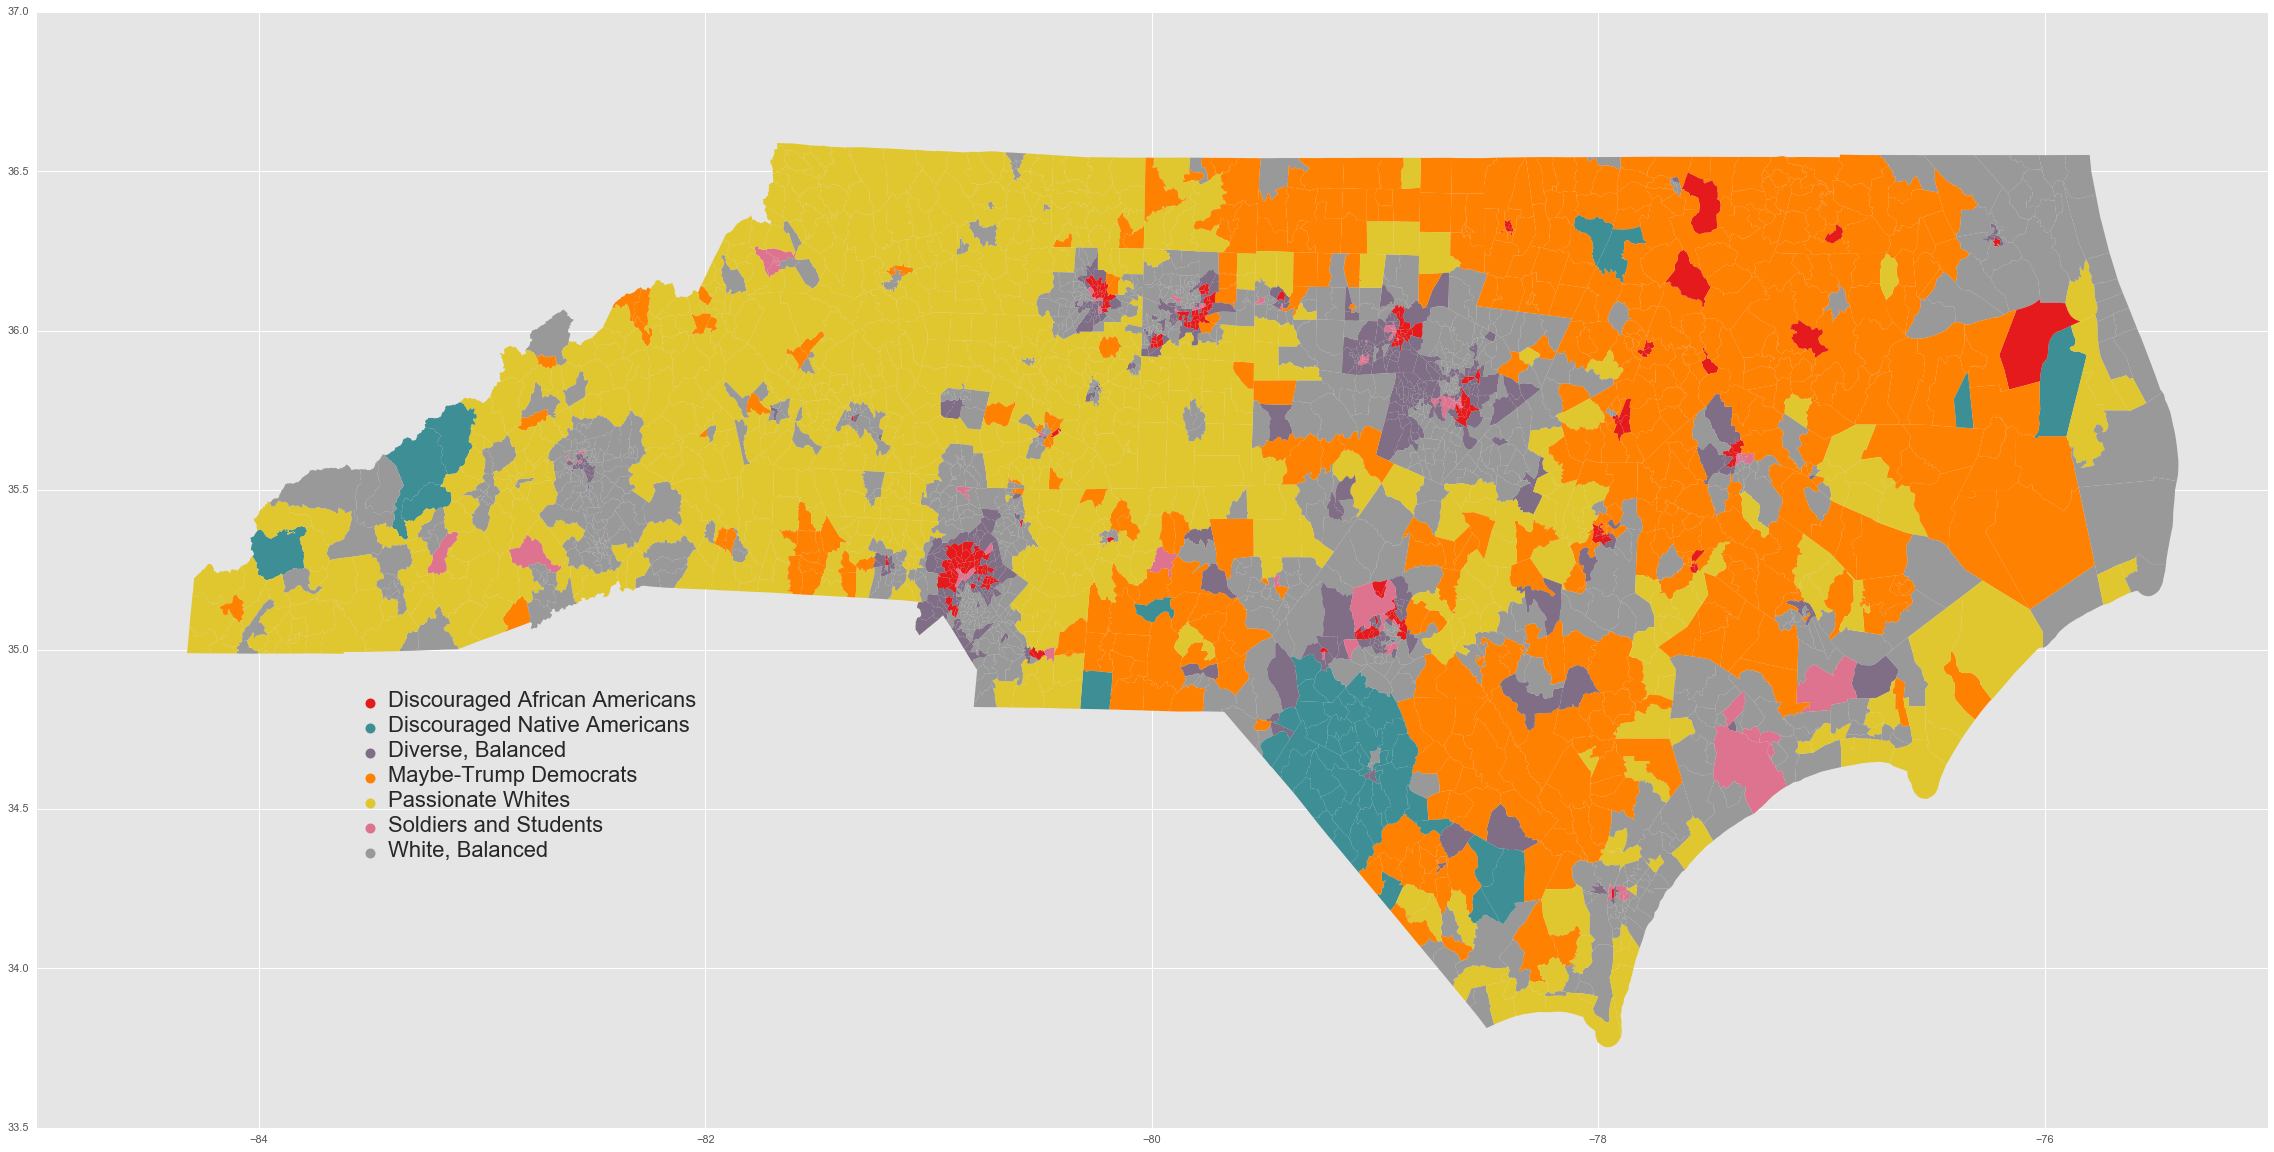

In [50]:
f, ax = plt.subplots(1, figsize=(40, 20))
ax = raw_nc_map.plot(column = 'cluster_definition', cmap='Set1', ax=ax, edgecolors='none',categorical=True, 
                      k=7,legend=True, alpha=1)
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.1, 0.2, 0.2, 0.2))

plt.setp(leg.get_texts(), fontsize='22') # for legend text
plt.setp(leg.get_title(), fontsize='32') # for legend title
plt.show()

Let's simplify the geocoding to reduce the size of the geojson

In [51]:
 raw_nc_map.loc[ : ,'geometry'] = (raw_nc_map.loc[:,'geometry']).simplify(0.0001, preserve_topology=True)

Save the new goejson as a json

In [52]:
with open('new_smaller_slim_cluster.json', 'w') as f:
    f.write(raw_nc_map.to_json())

The link below leads to the interactive visualization of the clusters

http://scott5.eastus.cloudapp.azure.com